In [ ]:
!nvidia-smi

Thu Feb 13 09:14:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Подготовка датасета


In [ ]:
from google.colab import drive
# Монтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!unrar x "/content/drive/MyDrive/Тестовые задания/ООО Комплексные системы/data.rar" /content/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Тестовые задания/ООО Комплексные системы/data.rar

Creating    /content/data                                             OK
Creating    /content/data/images                                      OK
Extracting  /content/data/images/vid_4_1000.jpg                            0%  OK 
Extracting  /content/data/images/vid_4_10000.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10020.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10040.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10060.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10080.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10100.jpg                           0%  OK 
Extracting  /content/data/images/vid_4_10120

In [ ]:
import pandas as pd
import os


df = pd.read_csv("/content/data/labels.csv")
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
df.info()
# всего 559 строк, нет пропусков,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB


In [ ]:
# количество пропусков по столбцам
df.isnull().sum()

,0
image,0
xmin,0
ymin,0
xmax,0
ymax,0


In [ ]:
# количество повторяющихся имен изображений
df['image'].duplicated().sum()

204

In [ ]:
# Количество уникальных имен изображений
unique_values_count = df['image'].nunique()
print("Количество уникальных значений в столбце image:")
print(unique_values_count)

Количество уникальных значений в столбце image:
355


То есть в датасете из 1001 изображения, машины есть только на 355 фото.
Вероятна разбалансировка классов и нужно увеличить аугментации изображений на которых есть машины

## преобразование в YOLO формат

In [ ]:
import pandas as pd
import os


df = pd.read_csv("/content/data/labels.csv")

# Ширина и высота изображения
img_width = 676
img_height = 380

# Функция для нормализации координат
def normalize_bbox(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return f"0 {x_center} {y_center} {width} {height}"

# Cловарь для хранения данных
output_data = {}

# Обрабатываем каждую строку в DataFrame
for index, row in df.iterrows():
    filename = row["image"]
    xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]

    # Нормализуем координаты
    bbox_str = normalize_bbox(xmin, ymin, xmax, ymax, img_width, img_height)

    # Добавляем bounding box в список для данного файла
    if filename not in output_data:
        output_data[filename] = []
    # Если в таблице csv несколько bb по одному названию image
    output_data[filename].append(bbox_str)

# Создаем текстовые файлы
output_dir = "/content/labels"  # Папка для сохранения файлов
os.makedirs(output_dir, exist_ok=True)  # Создаем папку, если она не существует

for filename, bbox_list in output_data.items():
    # Убираем расширение .jpg и добавляем .txt
    txt_filename = os.path.splitext(filename)[0] + ".txt"
    txt_path = os.path.join(output_dir, txt_filename)

    # Записываем все bounding box в файл
    with open(txt_path, "w") as f:
        for bbox in bbox_list:
            f.write(bbox + "\n")

print("Файлы успешно созданы в папке:", output_dir, "\n")

# Количество всех текстовых файлов с лейблами
label_files = [f for f in os.listdir(output_dir) if f.endswith('.txt')]
print(f"Количество текстовых файлов с лейблами: {len(label_files)}")

Файлы успешно созданы в папке: /content/labels 

Количество текстовых файлов с лейблами: 355


In [ ]:
# Пути к папкам
images_dir = "/content/data/images"  # Папка с изображениями
labels_dir = "/content/labels"  # Папка с текстовыми лейблами

# проверка количества изображений и текстовых лейблов к ним
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
len(image_files), len(label_files)

(1001, 355)

In [ ]:
# имена фото, где ЕСТЬ машины сохраним в car_name_image
car_name_image = [i for i in output_data.keys()]
print(len(car_name_image))
car_name_image[:5]

355


['vid_4_1000.jpg',
 'vid_4_10000.jpg',
 'vid_4_10040.jpg',
 'vid_4_10020.jpg',
 'vid_4_10060.jpg']

In [ ]:
# имена фото, где НЕТ машин сохраним в no_car_name_image
no_car_name_image = [i for i in image_files if i not in car_name_image]
len(no_car_name_image)
no_car_name_image[:5]

['vid_4_3780.jpg',
 'vid_4_4140.jpg',
 'vid_4_6800.jpg',
 'vid_4_6780.jpg',
 'vid_4_29360.jpg']

создаем пустые леблы для тех картинок, где нет bb (машин)

In [ ]:
# Получаем список всех изображений
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Получаем список всех текстовых файлов с лейблами
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Проходим по каждому изображению
for image_file in image_files:
    # Получаем имя файла без расширения
    image_name = os.path.splitext(image_file)[0]

    # Формируем имя текстового файла
    label_file = f"{image_name}.txt"

    # Если текстового файла нет, создаем пустой файл
    if label_file not in label_files:
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "w") as f:
            pass  # Создаем пустой файл
        print(f"Создан пустой файл: {label_file}")

print("Готово!")

image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
len(image_files), len(label_files)

Создан пустой файл: vid_4_3780.txt
Создан пустой файл: vid_4_4140.txt
Создан пустой файл: vid_4_6800.txt
Создан пустой файл: vid_4_6780.txt
Создан пустой файл: vid_4_29360.txt
Создан пустой файл: vid_4_7620.txt
Создан пустой файл: vid_4_29440.txt
Создан пустой файл: vid_4_10360.txt
Создан пустой файл: vid_4_3940.txt
Создан пустой файл: vid_4_10560.txt
Создан пустой файл: vid_4_9380.txt
Создан пустой файл: vid_4_19100.txt
Создан пустой файл: vid_4_26620.txt
Создан пустой файл: vid_4_1540.txt
Создан пустой файл: vid_4_7600.txt
Создан пустой файл: vid_4_22160.txt
Создан пустой файл: vid_4_18940.txt
Создан пустой файл: vid_4_29660.txt
Создан пустой файл: vid_4_14600.txt
Создан пустой файл: vid_4_7200.txt
Создан пустой файл: vid_4_5820.txt
Создан пустой файл: vid_4_11140.txt
Создан пустой файл: vid_4_6940.txt
Создан пустой файл: vid_4_29620.txt
Создан пустой файл: vid_4_4420.txt
Создан пустой файл: vid_4_3660.txt
Создан пустой файл: vid_4_22460.txt
Создан пустой файл: vid_4_7320.txt
Создан 

(1001, 1001)

In [ ]:
# добавим лейблы в архив
!zip -r labels.zip labels

  adding: labels/ (stored 0%)
  adding: labels/vid_4_8600.txt (deflated 28%)
  adding: labels/vid_4_17060.txt (deflated 27%)
  adding: labels/vid_4_21700.txt (stored 0%)
  adding: labels/vid_4_16160.txt (deflated 26%)
  adding: labels/vid_4_13840.txt (deflated 43%)
  adding: labels/vid_4_14340.txt (deflated 26%)
  adding: labels/vid_4_14180.txt (stored 0%)
  adding: labels/vid_4_13880.txt (deflated 41%)
  adding: labels/vid_4_29460.txt (deflated 27%)
  adding: labels/vid_4_13800.txt (deflated 41%)
  adding: labels/vid_4_5740.txt (stored 0%)
  adding: labels/vid_4_10340.txt (stored 0%)
  adding: labels/vid_4_7640.txt (stored 0%)
  adding: labels/vid_4_22440.txt (stored 0%)
  adding: labels/vid_4_19860.txt (stored 0%)
  adding: labels/vid_4_6960.txt (stored 0%)
  adding: labels/vid_4_1060.txt (deflated 26%)
  adding: labels/vid_4_29980.txt (deflated 25%)
  adding: labels/vid_4_23140.txt (stored 0%)
  adding: labels/vid_4_22720.txt (deflated 26%)
  adding: labels/vid_4_27180.txt (stored 0

## Cоздание датасета с Albumentations

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.3
    Uninstalling albumentations-2.0.3:
      Successfully uninstalled albumentations-2.0.3


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

In [ ]:
original_images_path = '/content/data/images'  # Папка с исходными изображениями
original_labels_folder='/content/labels'  # Папка c исходными лейблами

In [ ]:
# Фиксируем сид для воспроизводимости
def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)
A.random.seed(42)

# задаем трансформации
# Определение аугментаций
transform = A.Compose([
    A.HorizontalFlip(p=0.5), # Горизонтальное отражение
    A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=15, p=0.5), # Сдвиг, масштабирование, поворот
    #A.RandomResizedCrop(height=1024, width=1024, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),# Случайное кадрирование
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Случайная яркость и контраст
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5), # Изменение насыщенности и яркости
    A.OpticalDistortion(distort_limit=0.05, p=0.5), # Оптические искажения
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),# Эластичная деформация
    A.GaussNoise(p=0.5), # Гауссов шум
    A.MotionBlur(blur_limit=5, p=0.5),# Размытие в движении

], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))  # Параметры для bounding box

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def display_image_with_bboxes(image, bboxes, class_labels):
    """Отображает изображение с bounding boxes."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Размер изображения
    img_height, img_width, _ = image.shape

    # Добавление bounding boxes
    for bbox, class_label in zip(bboxes, class_labels):
        x_center, y_center, width, height = bbox
        # Преобразование из нормализованных координат в абсолютные пиксели
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        box_width = int(width * img_width)
        box_height = int(height * img_height)

        # Добавление прямоугольника на изображение
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        #ax.text(x_min, y_min - 5, f'Class {class_label}', color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()


def filter_bboxes(bboxes, class_labels, img_width, img_height, min_size=0.01):
    """Фильтрация bounding boxes и соответствующих меток классов."""
    valid_bboxes = []
    valid_class_labels = []
    for bbox, class_label in zip(bboxes, class_labels):
        x_center, y_center, width, height = bbox
        # Преобразование из нормализованных координат в пиксельные
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height

        # Проверка, что bounding box находится в пределах изображения и имеет ненулевую площадь
        if (
            x_min >= 0 and y_min >= 0 and x_max <= img_width and y_max <= img_height
            and width > min_size and height > min_size  # Фильтрация маленьких боксов
        ):
            valid_bboxes.append(bbox)
            valid_class_labels.append(class_label)
    return valid_bboxes, valid_class_labels

In [ ]:
#функция для создания аугментаций
def augment_and_save_with_bboxes(images_name, image_folder, labels_folder, output_image_folder, output_labels_folder, transform, num_augmentations=1, display_image=True, min_size=0.01):
    # Создаем папки для хранения аугментированных изображений и лейблов
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_labels_folder, exist_ok=True)

    for image_name in tqdm(images_name):
        # Путь к изображению и к файлу с лейблами
        image_path = os.path.join(image_folder, image_name)
        label_path = os.path.join(labels_folder, os.path.splitext(image_name)[0] + '.txt')

        # Загрузка изображения
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = image.shape

        # Загрузка bounding boxes
        bboxes = []
        class_labels = []
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(int(class_id))

        # Применение аугментаций и фильтрация результатов
        for i in range(num_augmentations):
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']
            augmented_class_labels = augmented['class_labels']

            # Фильтрация bounding boxes и меток классов с учетом минимального размера
            filtered_bboxes, filtered_class_labels = filter_bboxes(augmented_bboxes, augmented_class_labels, img_width, img_height, min_size=min_size)

            if display_image:
              # Отображение аугментированного изображения с bounding boxes для проверки
              print(f"Отображение аугментированного изображения {i+1} из {num_augmentations}")
              display_image_with_bboxes(augmented_image, filtered_bboxes, filtered_class_labels)

            # Сохранение аугментированного изображения
            aug_image_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
            aug_image_path = os.path.join(output_image_folder, aug_image_name)

            # Преобразование в формат uint8, если необходимо
            if augmented_image.dtype != np.uint8:
                augmented_image = (augmented_image * 255).astype(np.uint8)

            # Конвертация из RGB в BGR для сохранения с помощью OpenCV
            augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(aug_image_path, augmented_image)

            # Сохранение bounding boxes после фильтрации
            aug_label_path = os.path.join(output_labels_folder, f"{os.path.splitext(image_name)[0]}_aug_{i}.txt")
            with open(aug_label_path, 'w') as f:
                for bbox, class_id in zip(filtered_bboxes, filtered_class_labels):
                    x_center, y_center, width, height = bbox
                    f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


итого у нас 355 изображений с машинами и 646 изображений без машин. Для избежания дисбаланса классов делаю аугментацию изображений с машинами увелчивая количество изображений в 5 раз, а изображеий без машин в 3 раза.

In [ ]:
# делаем аугментации для изображений с машинами, увеличиваем количество фото в 5 раз
augment_and_save_with_bboxes(
    images_name = car_name_image, # изображения с машинами
    image_folder='/content/data/images',
    labels_folder='/content/labels',
    output_image_folder='/content/augmented_images/',
    output_labels_folder='/content/augmented_labels/',
    transform=transform,
    num_augmentations=5,
    display_image=False,
    min_size=0.005

)

100%|██████████| 355/355 [01:05<00:00,  5.38it/s]


In [ ]:
len(os.listdir('/content/augmented_images')), len(os.listdir('/content/augmented_labels'))

(1775, 1775)

In [ ]:
# делаем аугментации для изображений БЕЗ машина, увеличиваем количество фото в 3 раз
augment_and_save_with_bboxes(
    images_name = no_car_name_image, # изображения без машинам
    image_folder='/content/data/images',
    labels_folder='/content/labels',
    output_image_folder='/content/augmented_images/',
    output_labels_folder='/content/augmented_labels/',
    transform=transform,
    num_augmentations=3,
    display_image=False,
    min_size=0.005

)

100%|██████████| 646/646 [00:51<00:00, 12.51it/s]


In [ ]:
len(os.listdir('/content/augmented_images')), len(os.listdir('/content/augmented_labels'))

(3713, 3713)

1126


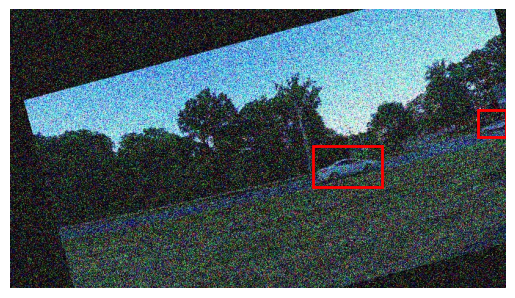

In [ ]:
# проверяем аугментацию, отображаем картинку и bb

# рандомное число
n = random.randint(0, len(os.listdir('/content/augmented_images')))
print(n)

# Задайте пути к аугментированному изображению и файлу с лейблами
aug_image_name_path = os.listdir('/content/augmented_images')
aug_image_path = os.path.join('/content/augmented_images', aug_image_name_path[n]) # Путь к одному из аугментированных изображений
aug_label_path = os.path.join('/content/augmented_labels', f"{os.path.splitext(aug_image_name_path[n])[0]}.txt") # Путь к соответствующему файлу с лейблами

# Загрузка изображения из файла
image = cv2.imread(aug_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование из BGR в RGB для корректного отображения в matplotlib
# Загрузка bounding boxes из файла
bboxes = []
class_labels = []
with open(aug_label_path, 'r') as f:
    for line in f:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(int(class_id))

# Отображение изображения с bounding boxes
display_image_with_bboxes(image, bboxes, class_labels)


## Разделение на train, val, test выборки

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Указание путей
images_path = '/content/augmented_images'
labels_path = '/content/augmented_labels'
train_images_path = '/content/train/images'
val_images_path = '/content/val/images'
test_images_path = '/content/test/images'
train_labels_path = '/content/train/labels'
val_labels_path = '/content/val/labels'
test_labels_path = '/content/test/labels'

# Создание папок для train и val, если они еще не существуют
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)


# Получение списка всех файлов изображений и меток
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.txt')])

# Проверка, что у каждого изображения есть соответствующий файл меток
image_files = [f for f in image_files if os.path.exists(os.path.join(labels_path, f.replace('.jpg', '.txt')))]
label_files = [f for f in label_files if os.path.exists(os.path.join(images_path, f.replace('.txt', '.jpg')))]

# Разделение на тренировочный набор
train_images, v_images, train_labels, v_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42  # 80% train, 20% прочая
)
# Разделение на валидационную и тестовую выборки
val_images, test_images, val_labels, test_labels = train_test_split(
    v_images, v_labels, test_size=0.25, random_state=42  # Итого 80% train, 15% val, 5% test
)

# Функция для перемещения файлов
def move_files(file_list, source_folder, target_folder):
    for file_name in file_list:
        shutil.move(os.path.join(source_folder, file_name), os.path.join(target_folder, file_name))

# Перемещение файлов в соответствующие папки
move_files(train_images, images_path, train_images_path)
move_files(val_images, images_path, val_images_path)
move_files(test_images, images_path, test_images_path)
move_files(train_labels, labels_path, train_labels_path)
move_files(val_labels, labels_path, val_labels_path)
move_files(test_labels, labels_path, test_labels_path)

print("Разделение данных завершено.")

Разделение данных завершено.


In [ ]:
print(len([f for f in os.listdir(train_images_path) if f.endswith('.jpg')]), len([f for f in os.listdir(train_labels_path) if f.endswith('.txt')]))
print(len([f for f in os.listdir(val_images_path) if f.endswith('.jpg')]), len([f for f in os.listdir(val_labels_path) if f.endswith('.txt')]))
print(len([f for f in os.listdir(test_images_path) if f.endswith('.jpg')]), len([f for f in os.listdir(test_labels_path) if f.endswith('.txt')]))

2970 2970
557 557
186 186


In [ ]:
# создаем отдельную папку для датасета, перемещаем туда train, val, test
os.mkdir('/content/dataset_albumentations')

In [ ]:
!zip -r dataset_albumentations.zip /content/dataset_albumentations

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: content/dataset_albumentations/train/images/vid_4_9240_aug_3.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_11220_aug_1.jpg (deflated 1%)
  adding: content/dataset_albumentations/train/images/vid_4_12160_aug_2.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_600_aug_2.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_14060_aug_1.jpg (deflated 1%)
  adding: content/dataset_albumentations/train/images/vid_4_19420_aug_1.jpg (deflated 3%)
  adding: content/dataset_albumentations/train/images/vid_4_22100_aug_0.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_5880_aug_0.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_23380_aug_0.jpg (deflated 0%)
  adding: content/dataset_albumentations/train/images/vid_4_6480_aug_2.jpg (deflated 0%)
  adding: content/dataset_albumentati

# Обучение

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.3/107.7 GB disk)


In [ ]:
# фиксация seed
def set_seed(seed_value=42):
    import torch
    import random
    import numpy as np
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)

set_seed(42)

In [ ]:
!yolo task=detect mode=train model=yolo11n.pt data=/content/dataset_albumentations/data.yaml epochs=50 imgsz=640 plots=True batch=8

New https://pypi.org/project/ultralytics/8.3.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset_albumentations/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

In [ ]:
!ls {HOME}/runs/detect/train2/

args.yaml					    R_curve.png		  val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		  val_batch0_pred.jpg
confusion_matrix.png				    results.png		  val_batch1_labels.jpg
events.out.tfevents.1739438959.1187b415ace0.4638.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					    train_batch14880.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch14881.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch14882.jpg  weights
P_curve.png					    train_batch1.jpg
PR_curve.png					    train_batch2.jpg


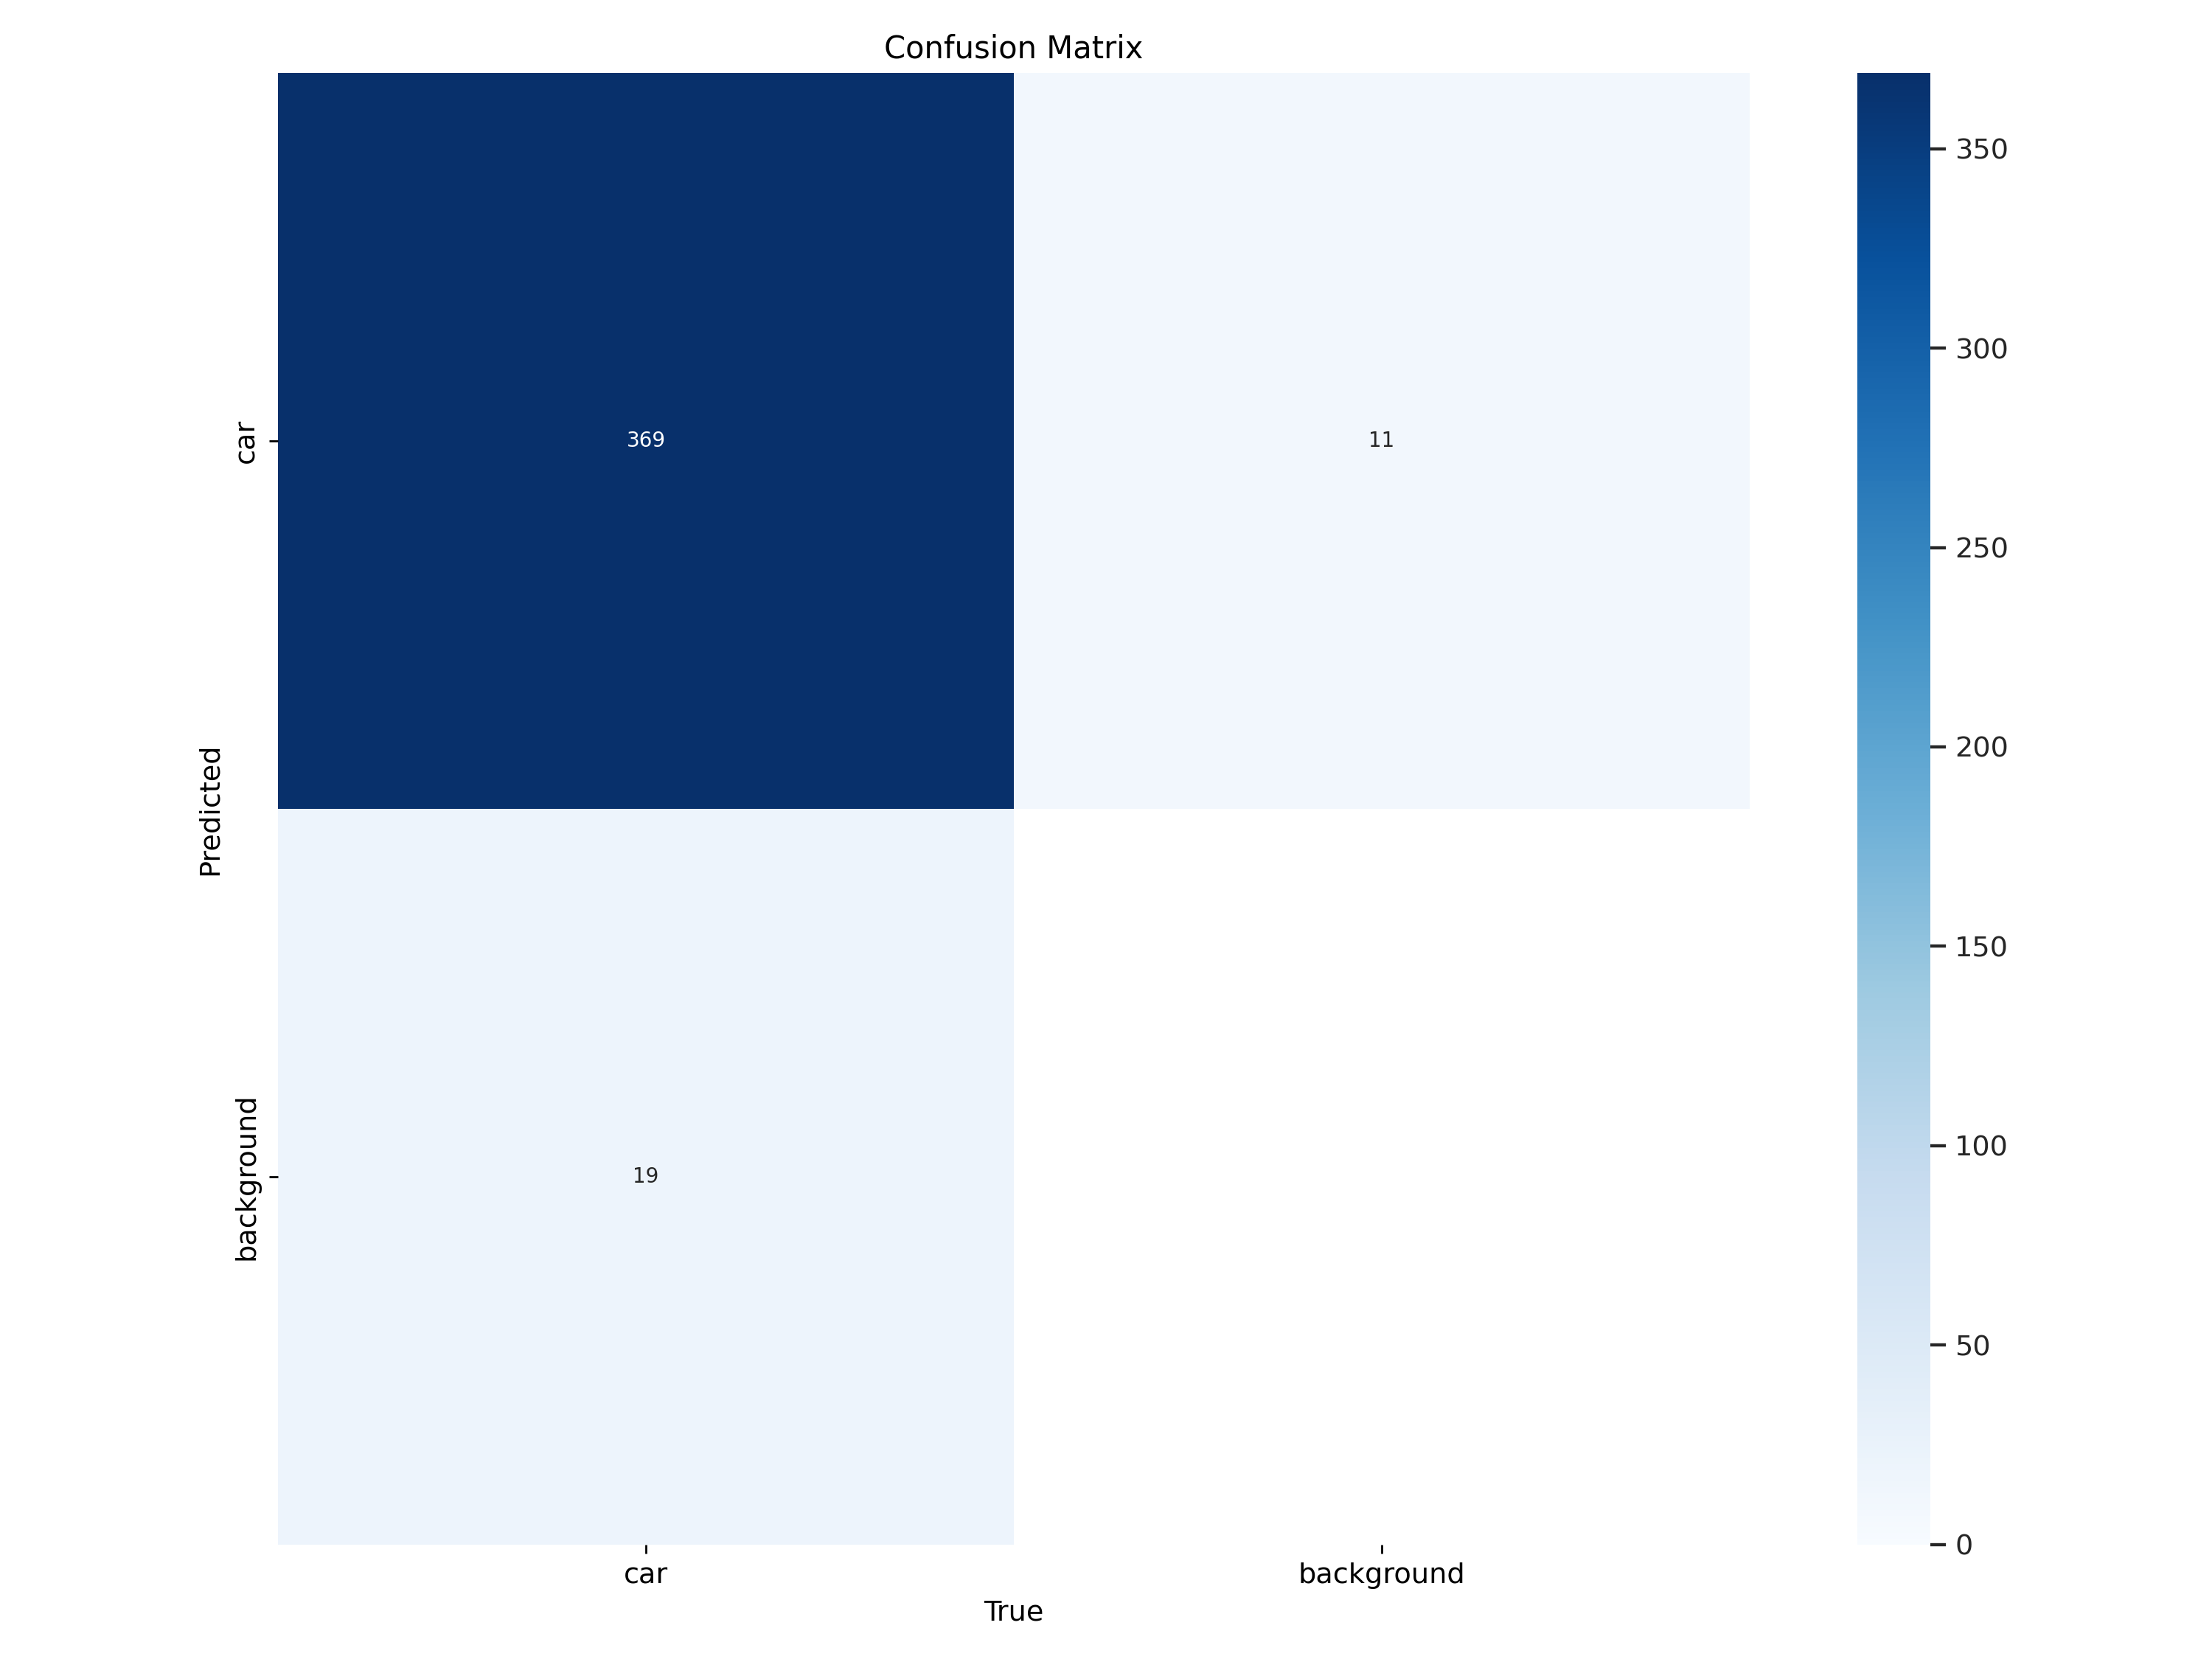

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

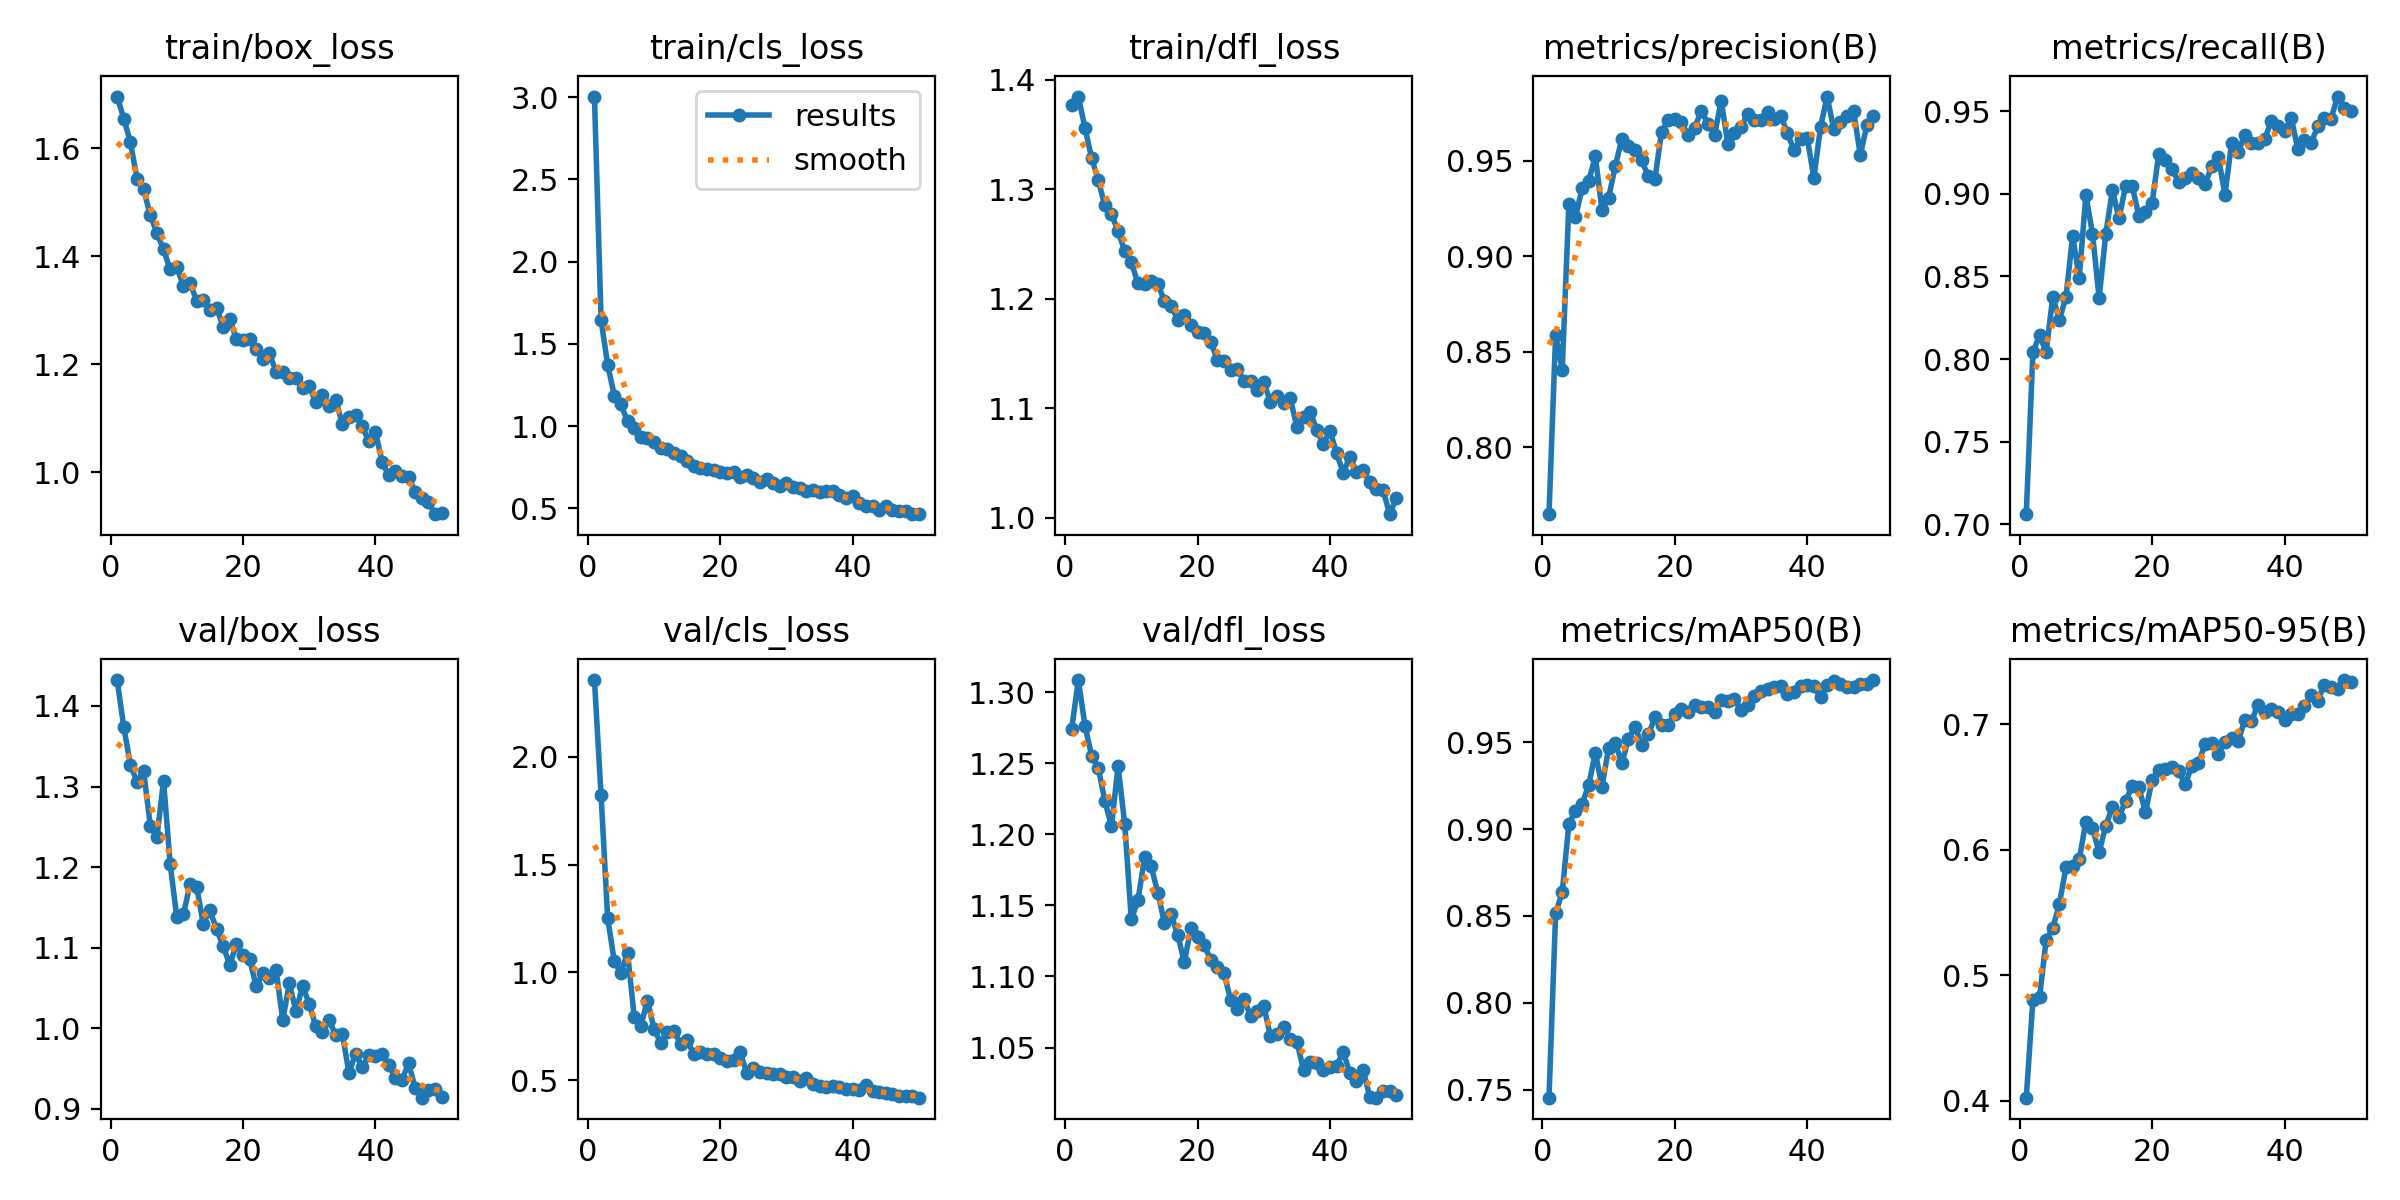

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

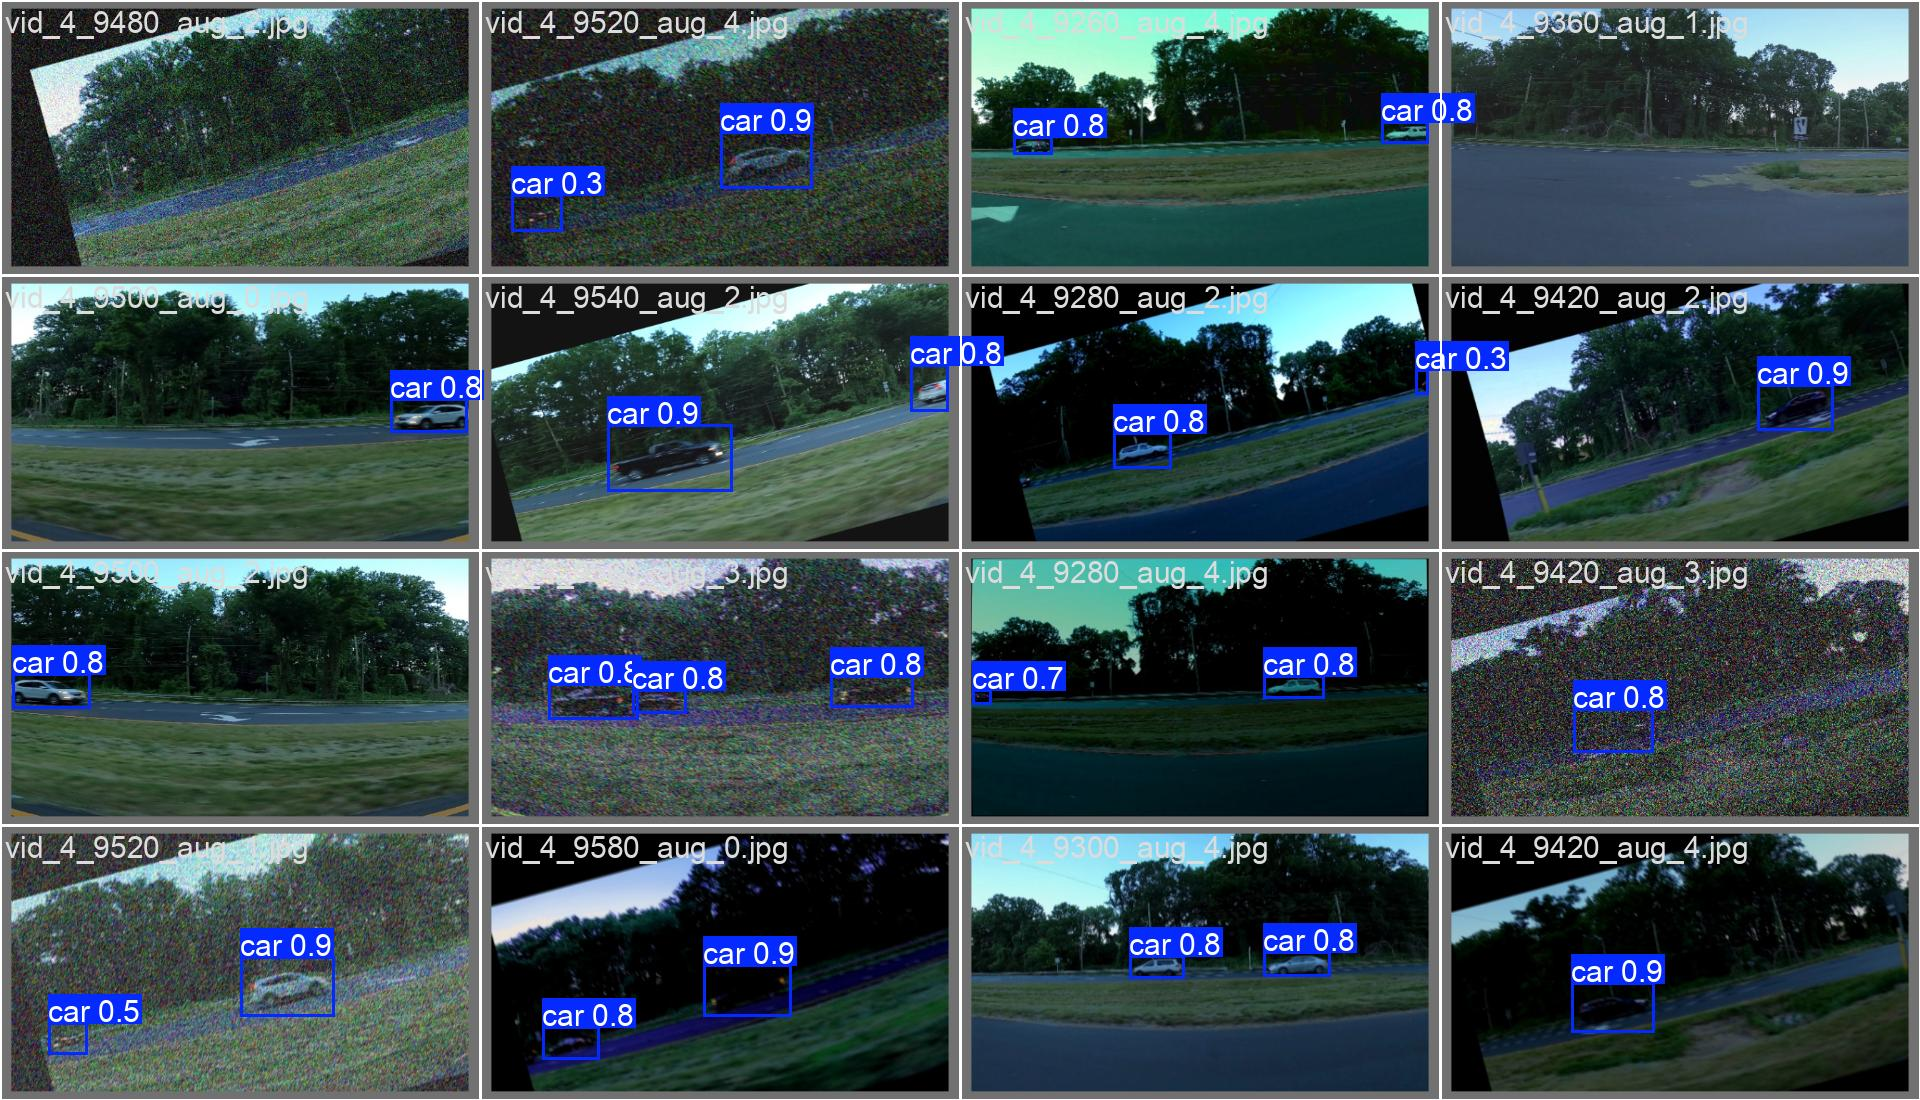

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data=/content/dataset_albumentations/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/dataset_albumentations/val/labels.cache... 557 images, 303 backgrounds, 0 corrupt: 100% 557/557 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 35/35 [00:04<00:00,  7.53it/s]
                   all        557        388      0.969      0.952      0.984      0.734
Speed: 0.6ms preprocess, 3.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
# сохраняю графики с метриками на val выборке
!zip -r rezult_val.zip /content/runs/detect/val

  adding: content/runs/detect/val/ (stored 0%)
  adding: content/runs/detect/val/confusion_matrix_normalized.png (deflated 38%)
  adding: content/runs/detect/val/val_batch0_labels.jpg (deflated 8%)
  adding: content/runs/detect/val/val_batch0_pred.jpg (deflated 7%)
  adding: content/runs/detect/val/val_batch2_pred.jpg (deflated 7%)
  adding: content/runs/detect/val/val_batch1_pred.jpg (deflated 7%)
  adding: content/runs/detect/val/P_curve.png (deflated 23%)
  adding: content/runs/detect/val/PR_curve.png (deflated 27%)
  adding: content/runs/detect/val/val_batch1_labels.jpg (deflated 7%)
  adding: content/runs/detect/val/val_batch2_labels.jpg (deflated 7%)
  adding: content/runs/detect/val/R_curve.png (deflated 17%)
  adding: content/runs/detect/val/confusion_matrix.png (deflated 39%)
  adding: content/runs/detect/val/F1_curve.png (deflated 17%)


## Экспорт в ONNX

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("/content/runs/detect/train2/weights/best.pt")

In [ ]:
# Export the model to ONNX format
model.export(format="onnx")  # creates 'best.onnx'

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 218.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 211.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 290.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 217.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 248.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 19.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun comma

'/content/runs/detect/train2/weights/best.onnx'

## Результат на тестовой выборке

In [ ]:
# Load the exported ONNX model
onnx_model = YOLO("/content/runs/detect/train2/weights/best.onnx")

# Run inference
results = onnx_model("/content/dataset_albumentations/test/images/vid_4_10980_aug_0.jpg", save=True)

Loading /content/runs/detect/train2/weights/best.onnx for ONNX Runtime inference...
Preferring ONNX Runtime TensorrtExecutionProvider
*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:507 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************

image 1/1 /content/dataset_albumentations/test/images/vid_4_10980_aug_0.jpg: 640x640 1 car, 11.6ms
Speed: 4.6ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


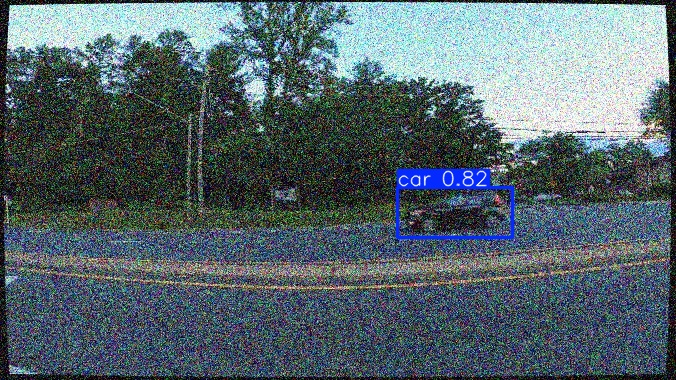

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/predict/vid_4_10980_aug_0.jpg', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.onnx data=/content/dataset_albumentations/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
Loading /content/runs/detect/train2/weights/best.onnx for ONNX Runtime inference...
Preferring ONNX Runtime AzureExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Scanning /content/dataset_albumentations/test/labels... 186 images, 100 backgrounds, 0 corrupt: 100% 186/186 [00:00<00:00, 1473.66it/s]
val: New cache created: /content/dataset_albumentations/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 186/186 [00:24<00:00,  7.61it/s]
                   all        186        132      0.969      0.953      0.982      0.733
Speed: 5.6ms preprocess, 116.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at https://docs.ultralytics.com/modes/val


/content/runs/detect/val3/confusion_matrix_normalized.png


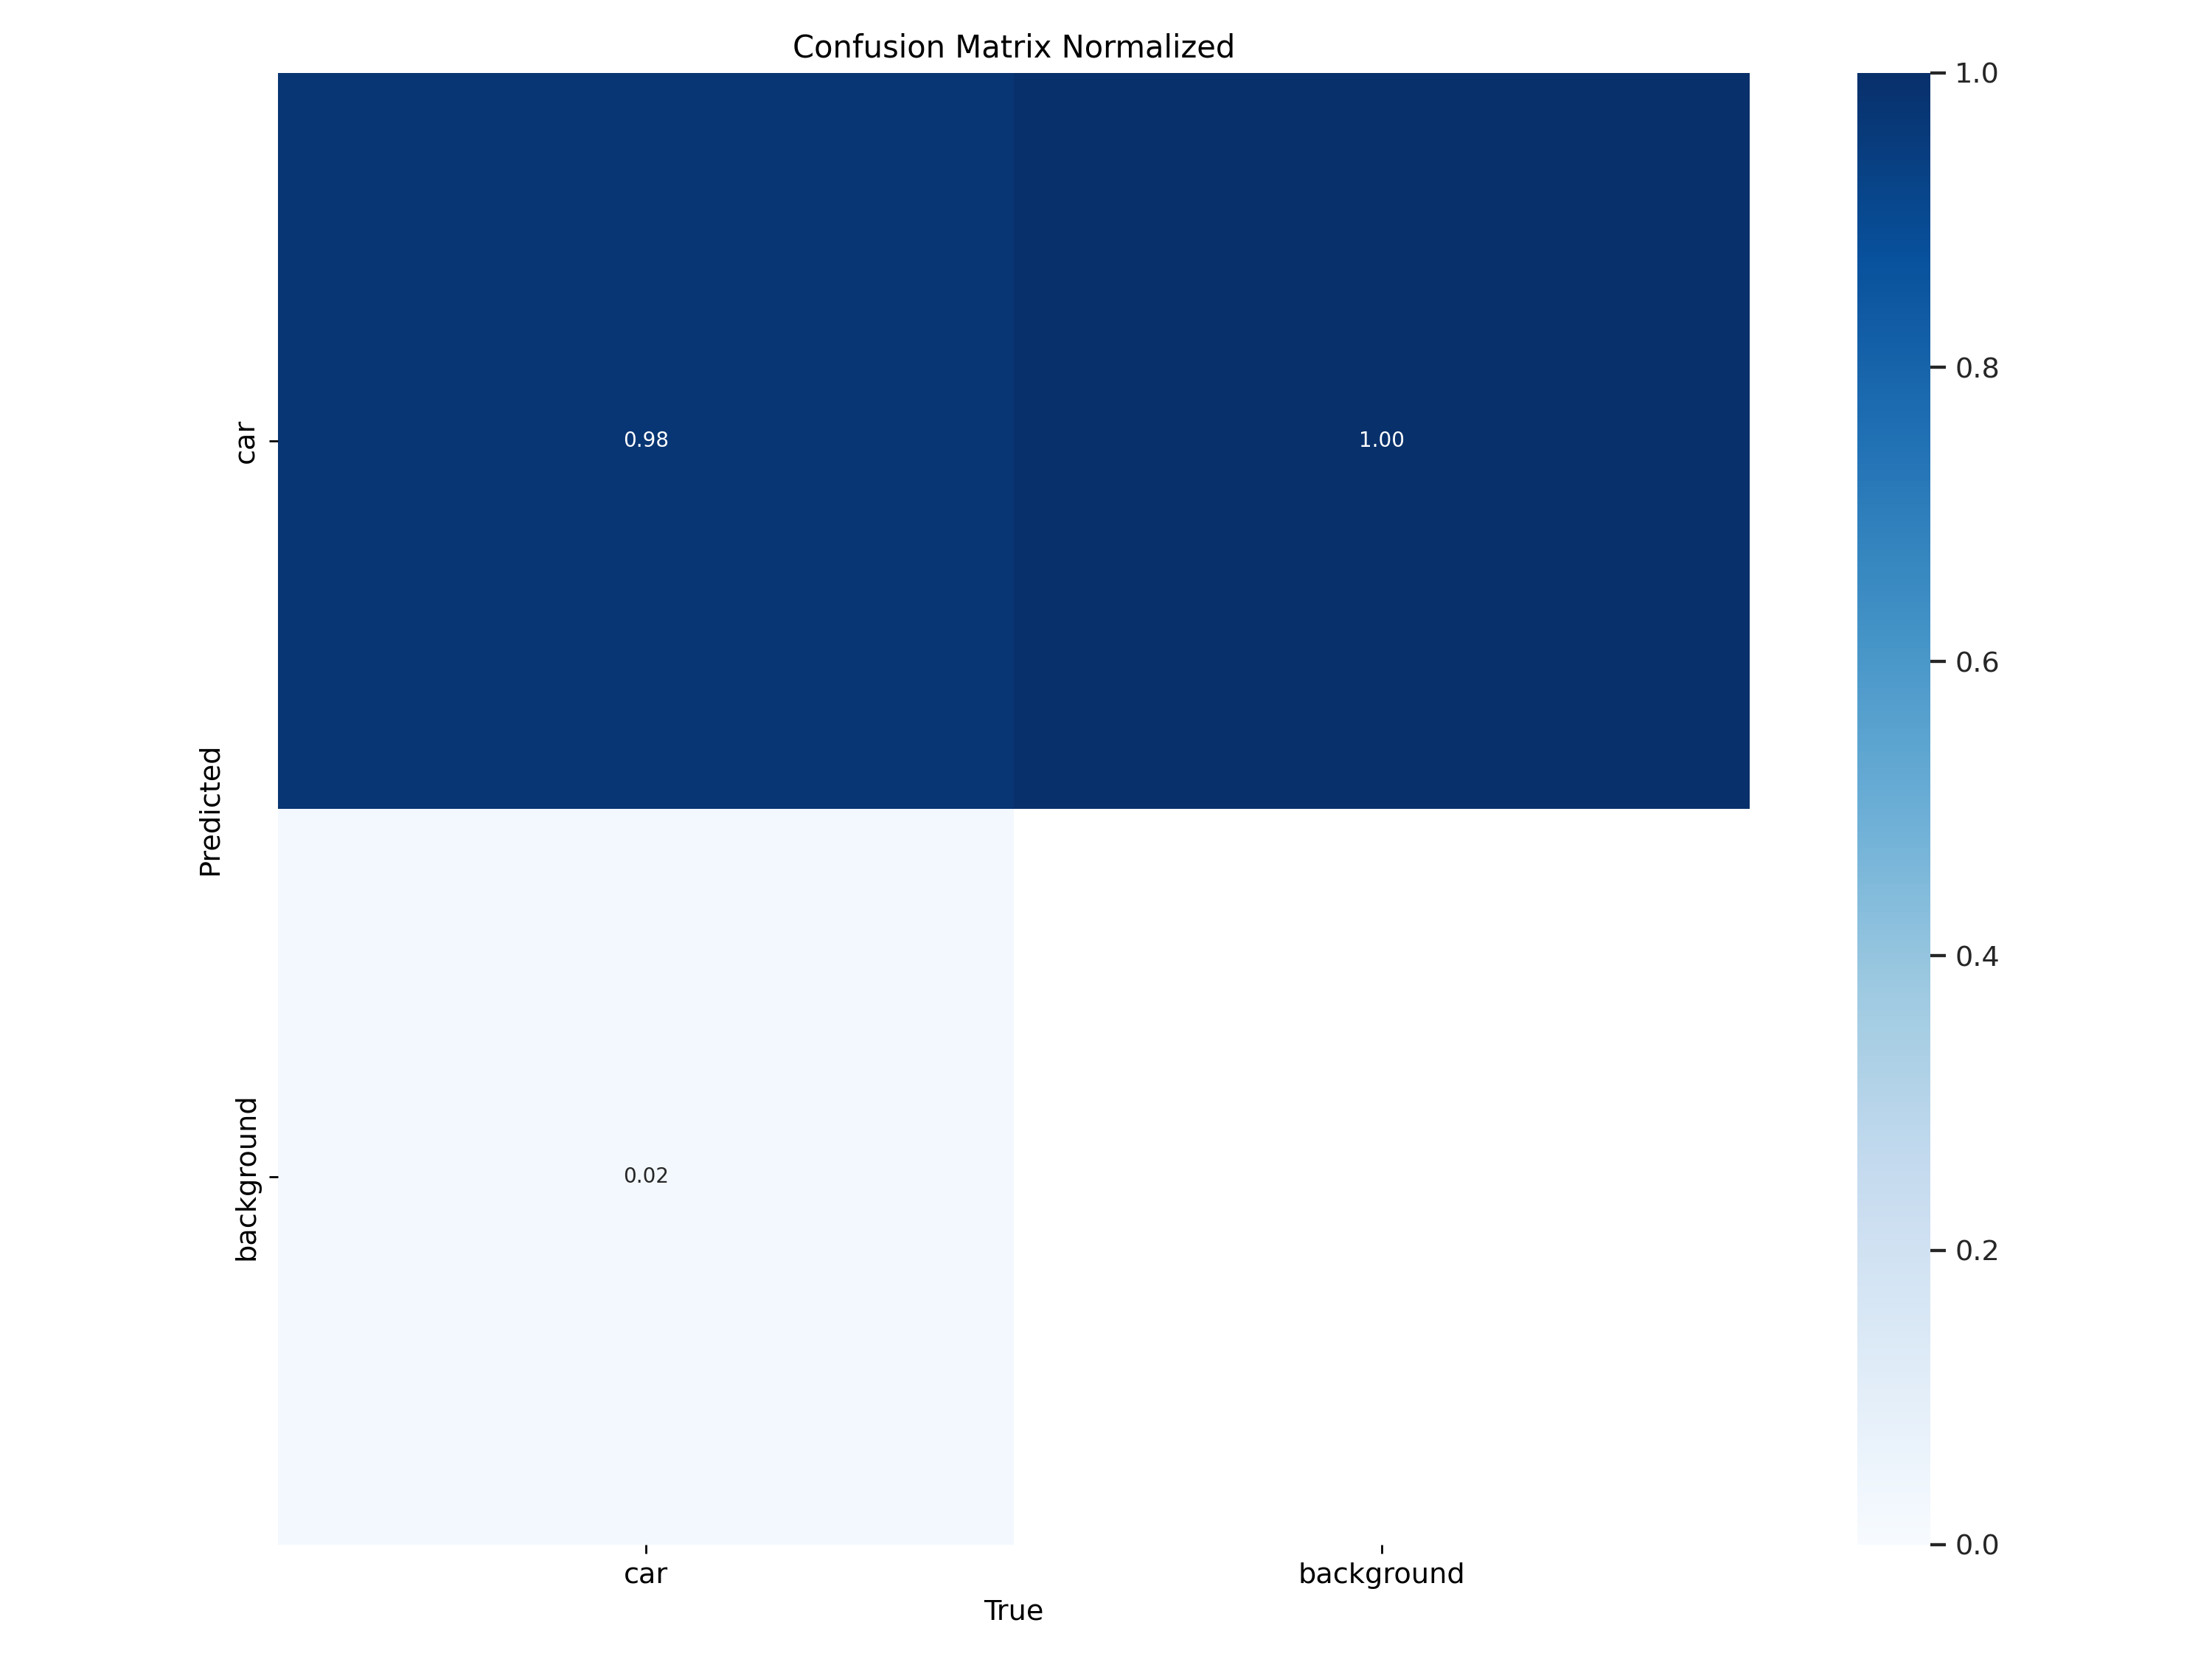

/content/runs/detect/val3/val_batch0_labels.jpg


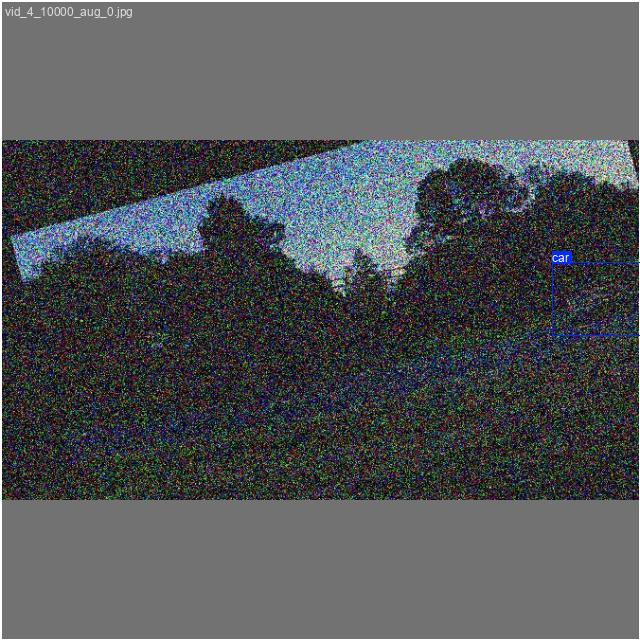

/content/runs/detect/val3/val_batch0_pred.jpg


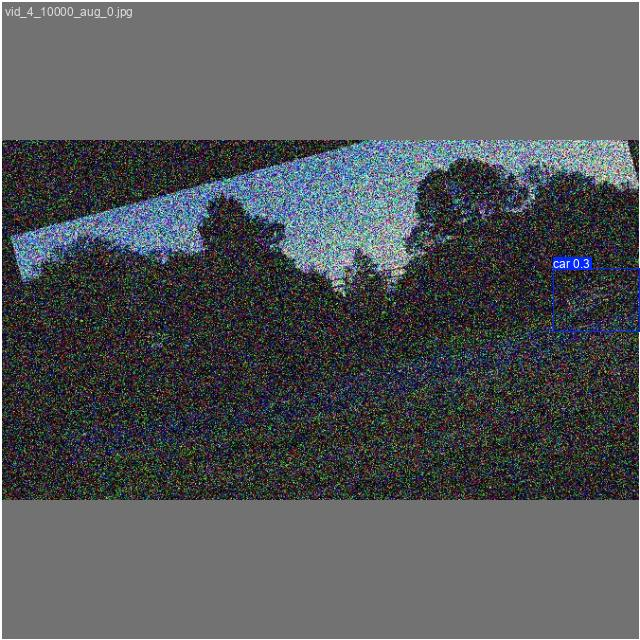

/content/runs/detect/val3/val_batch2_pred.jpg


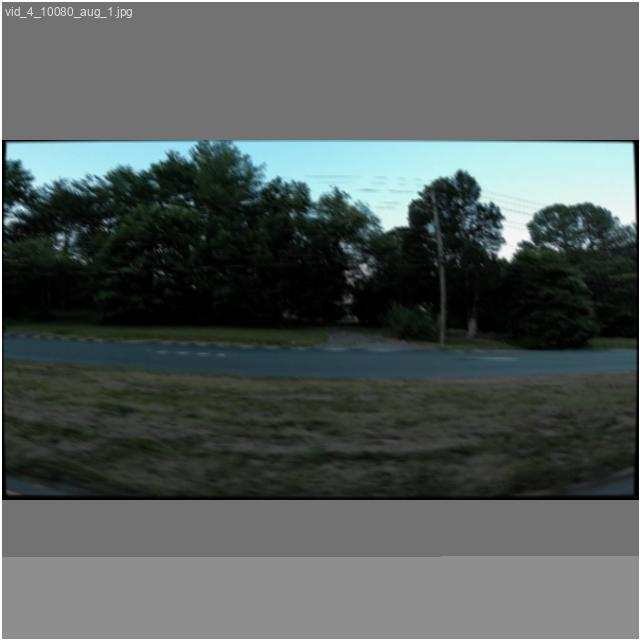

/content/runs/detect/val3/val_batch1_pred.jpg


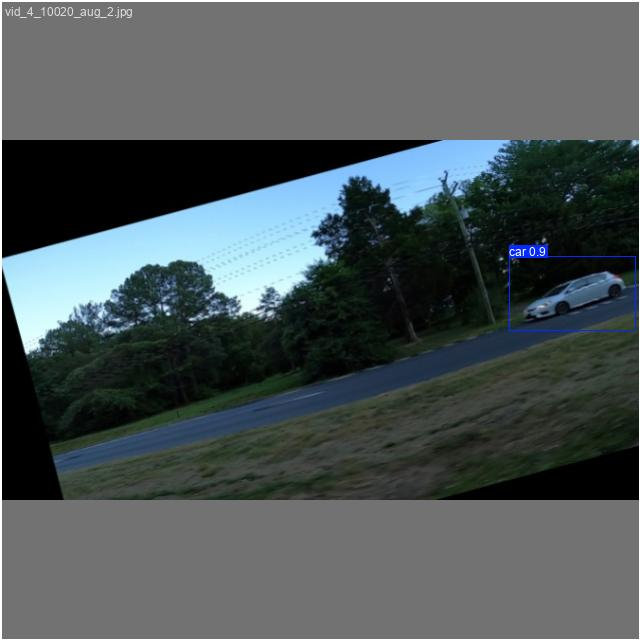

/content/runs/detect/val3/P_curve.png


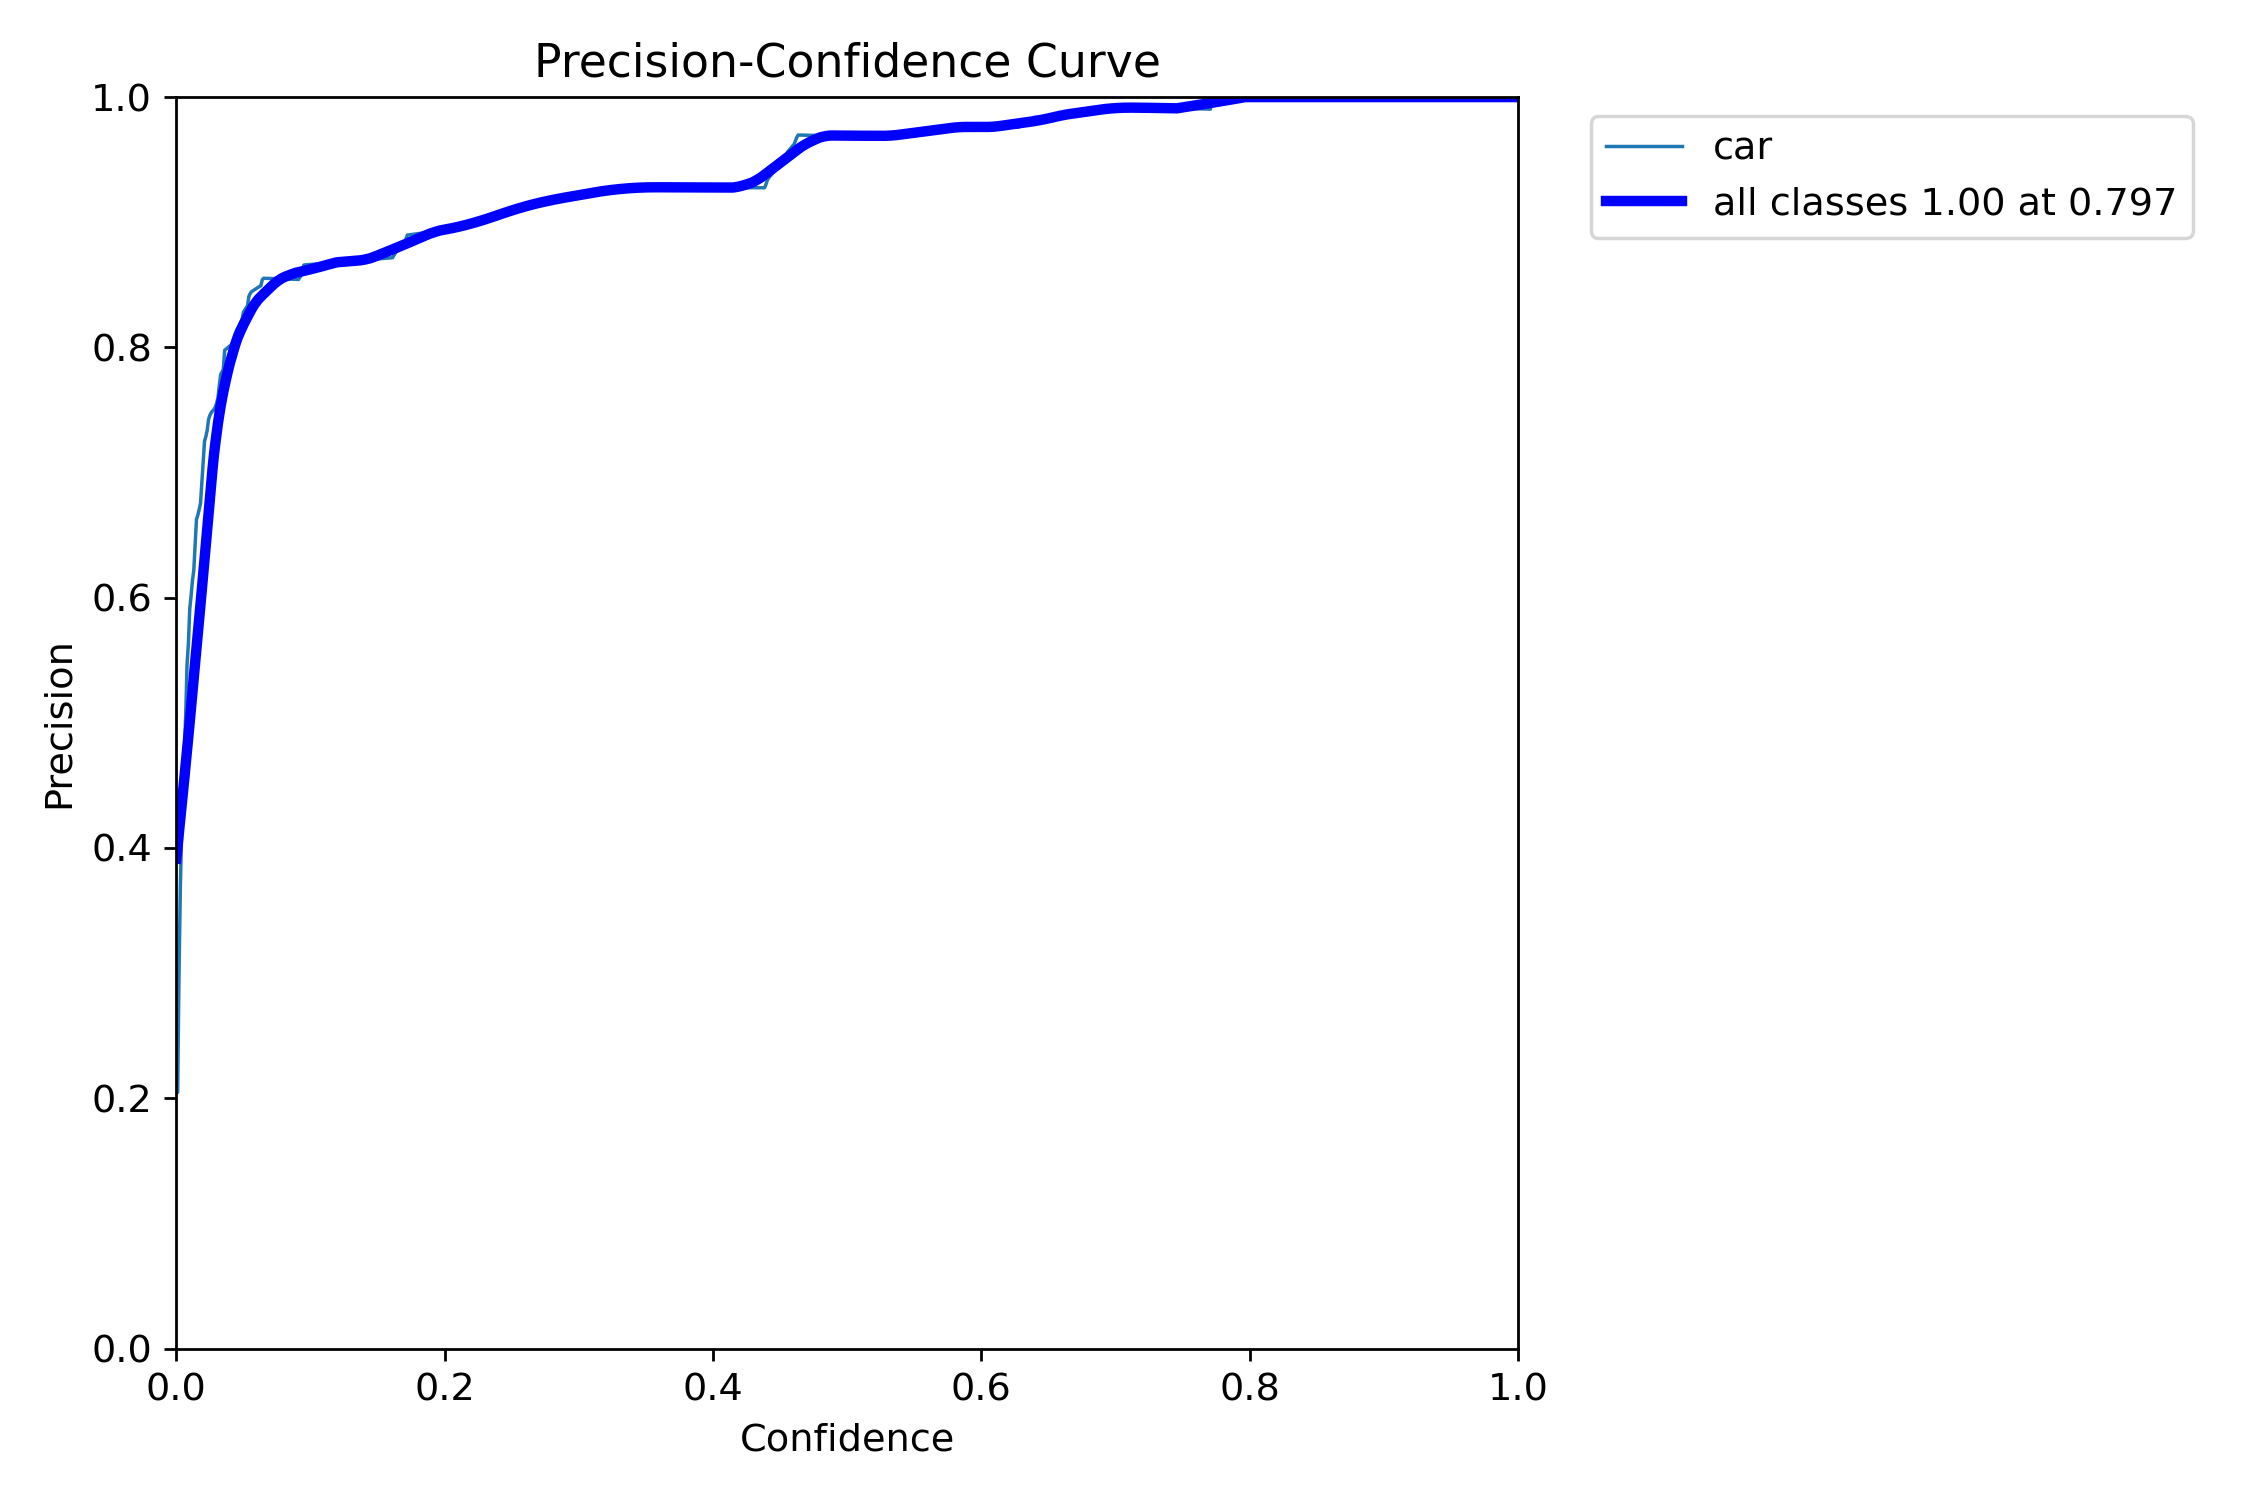

/content/runs/detect/val3/PR_curve.png


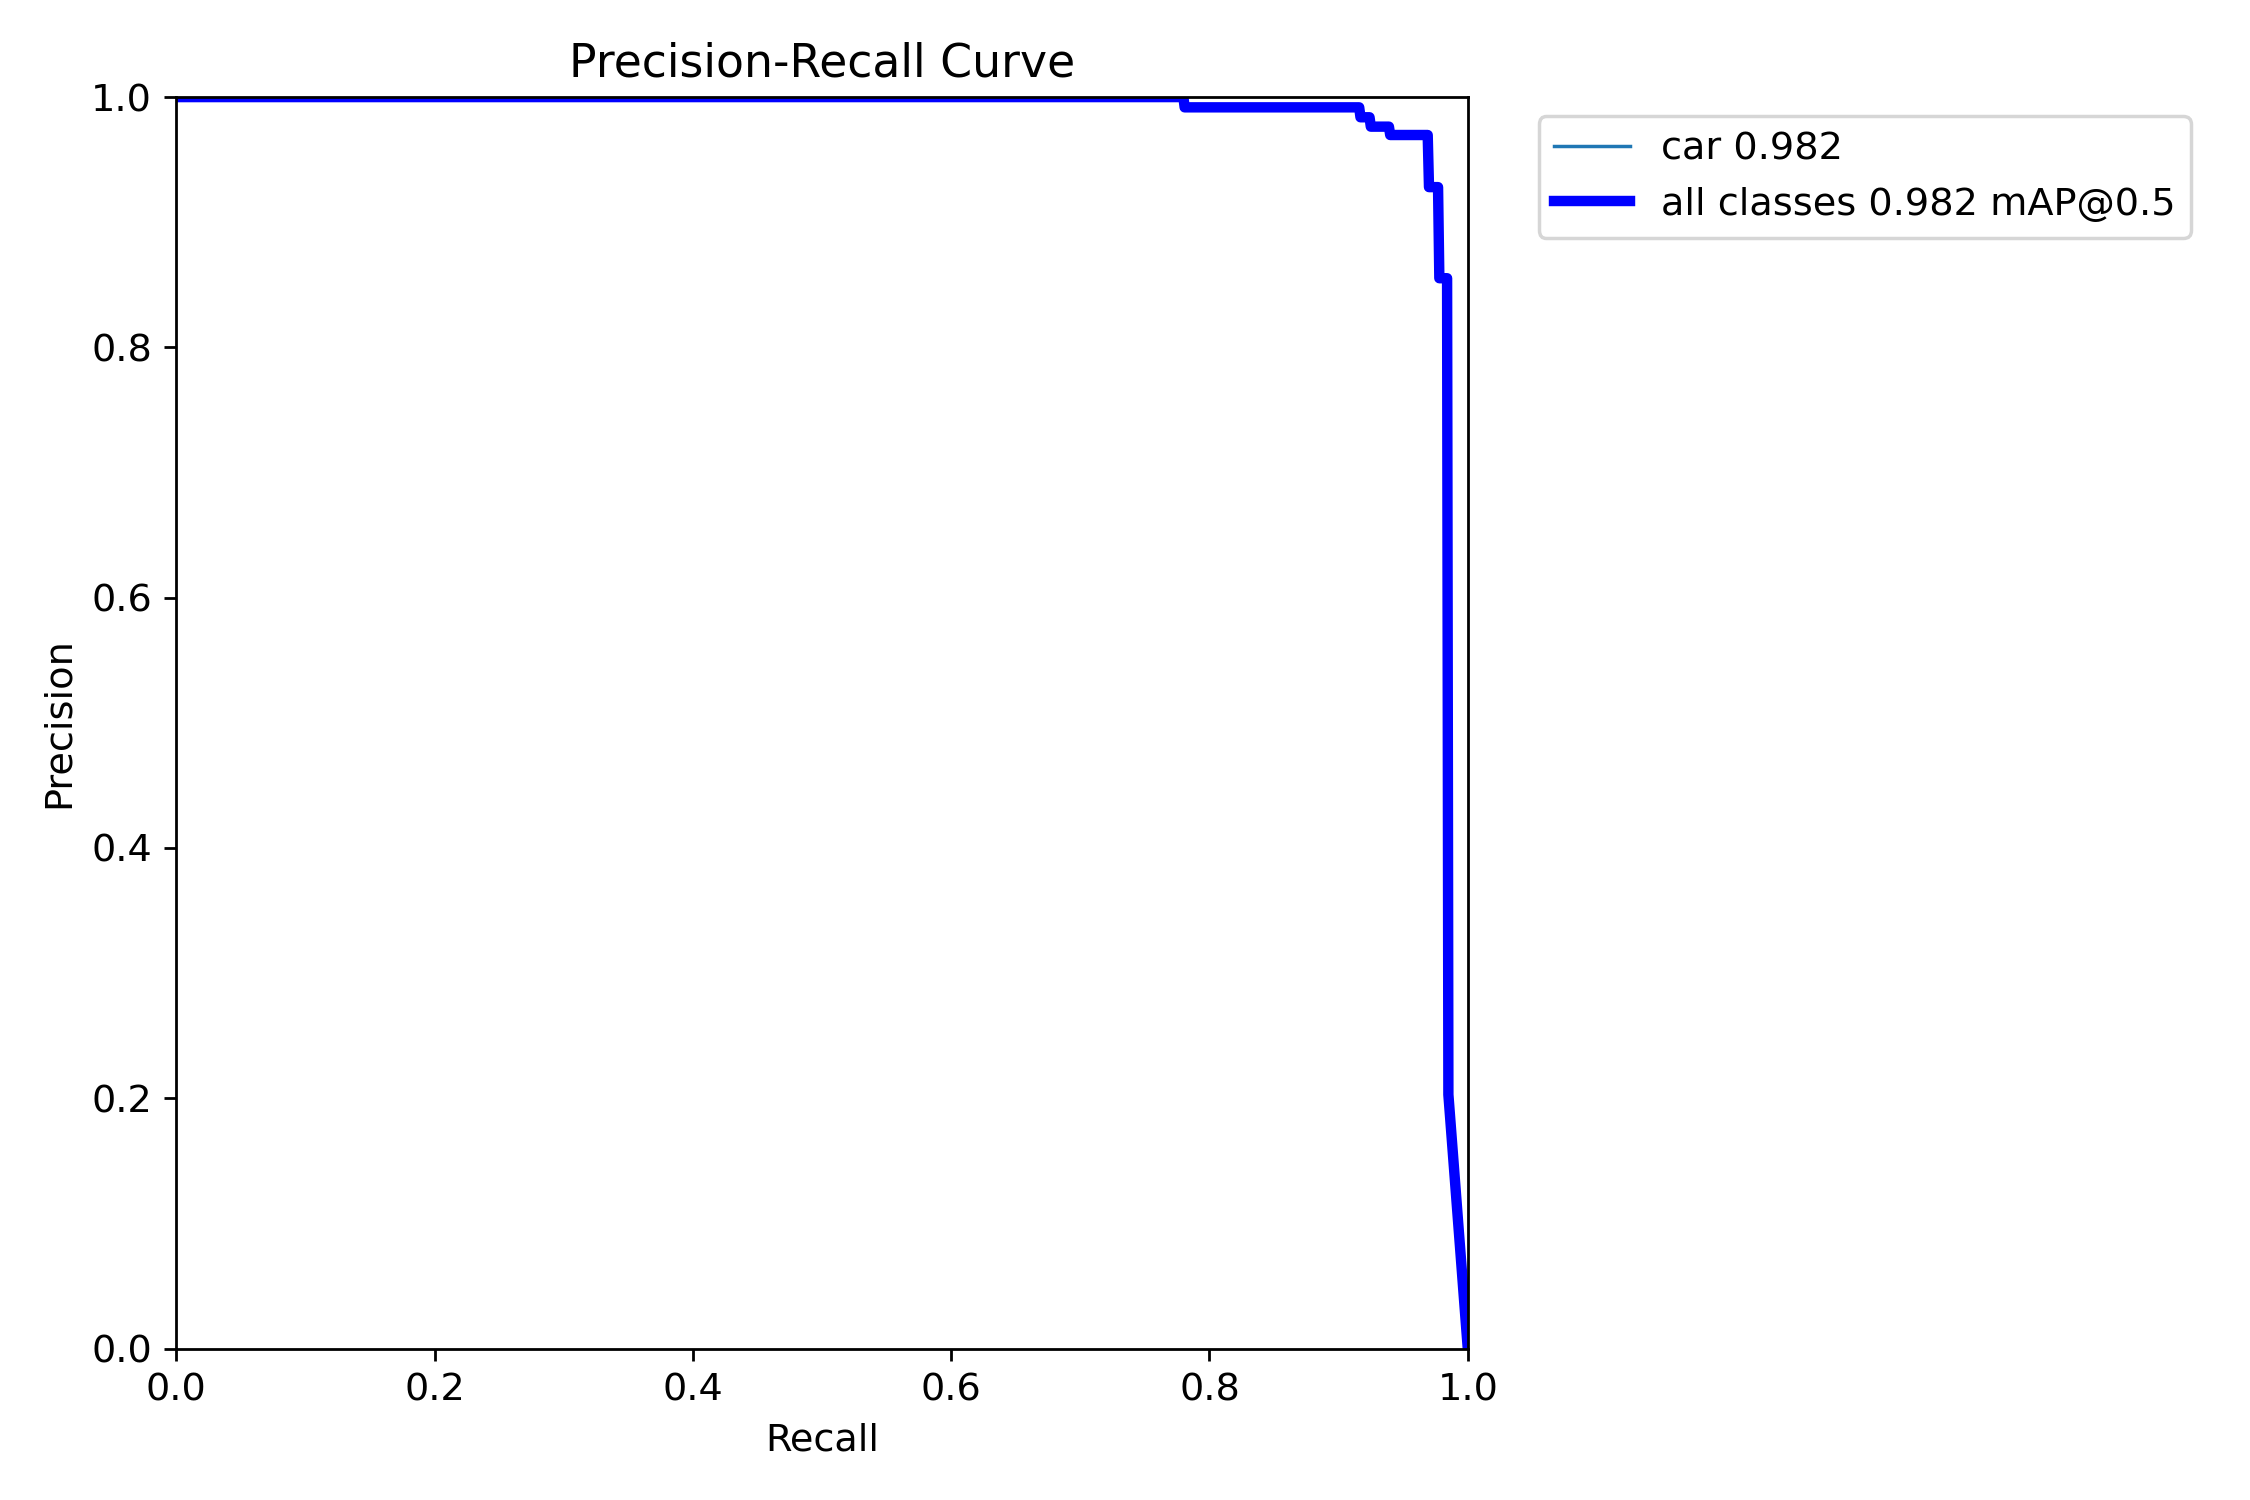

/content/runs/detect/val3/val_batch1_labels.jpg


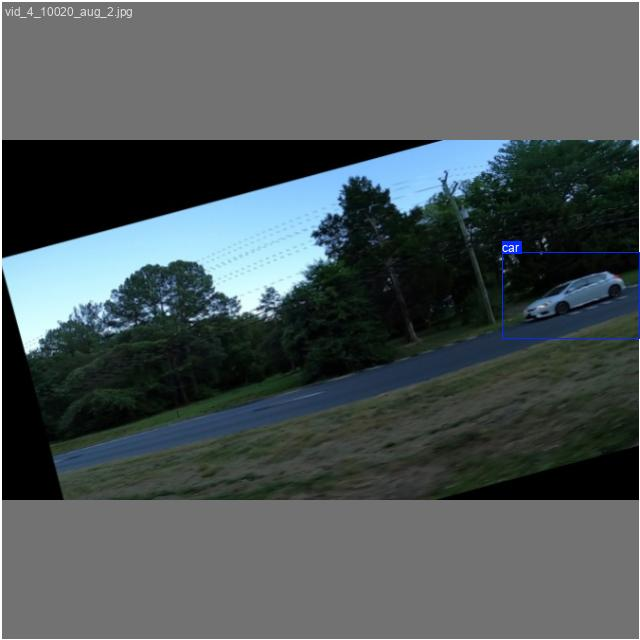

/content/runs/detect/val3/val_batch2_labels.jpg


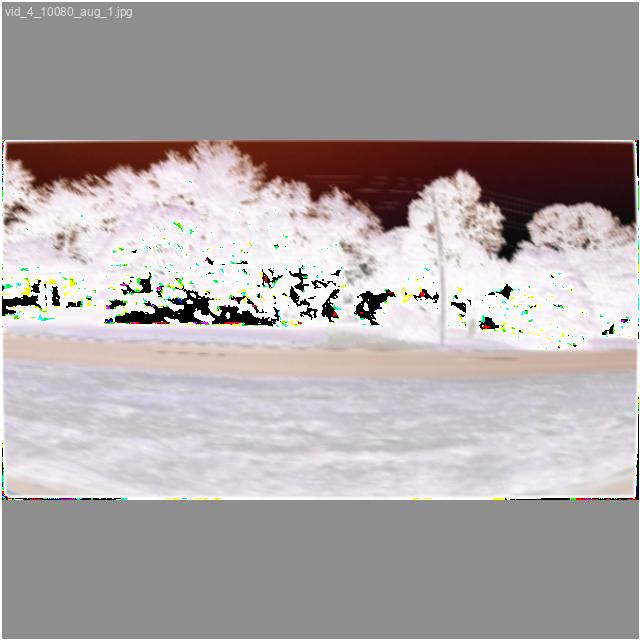

/content/runs/detect/val3/R_curve.png


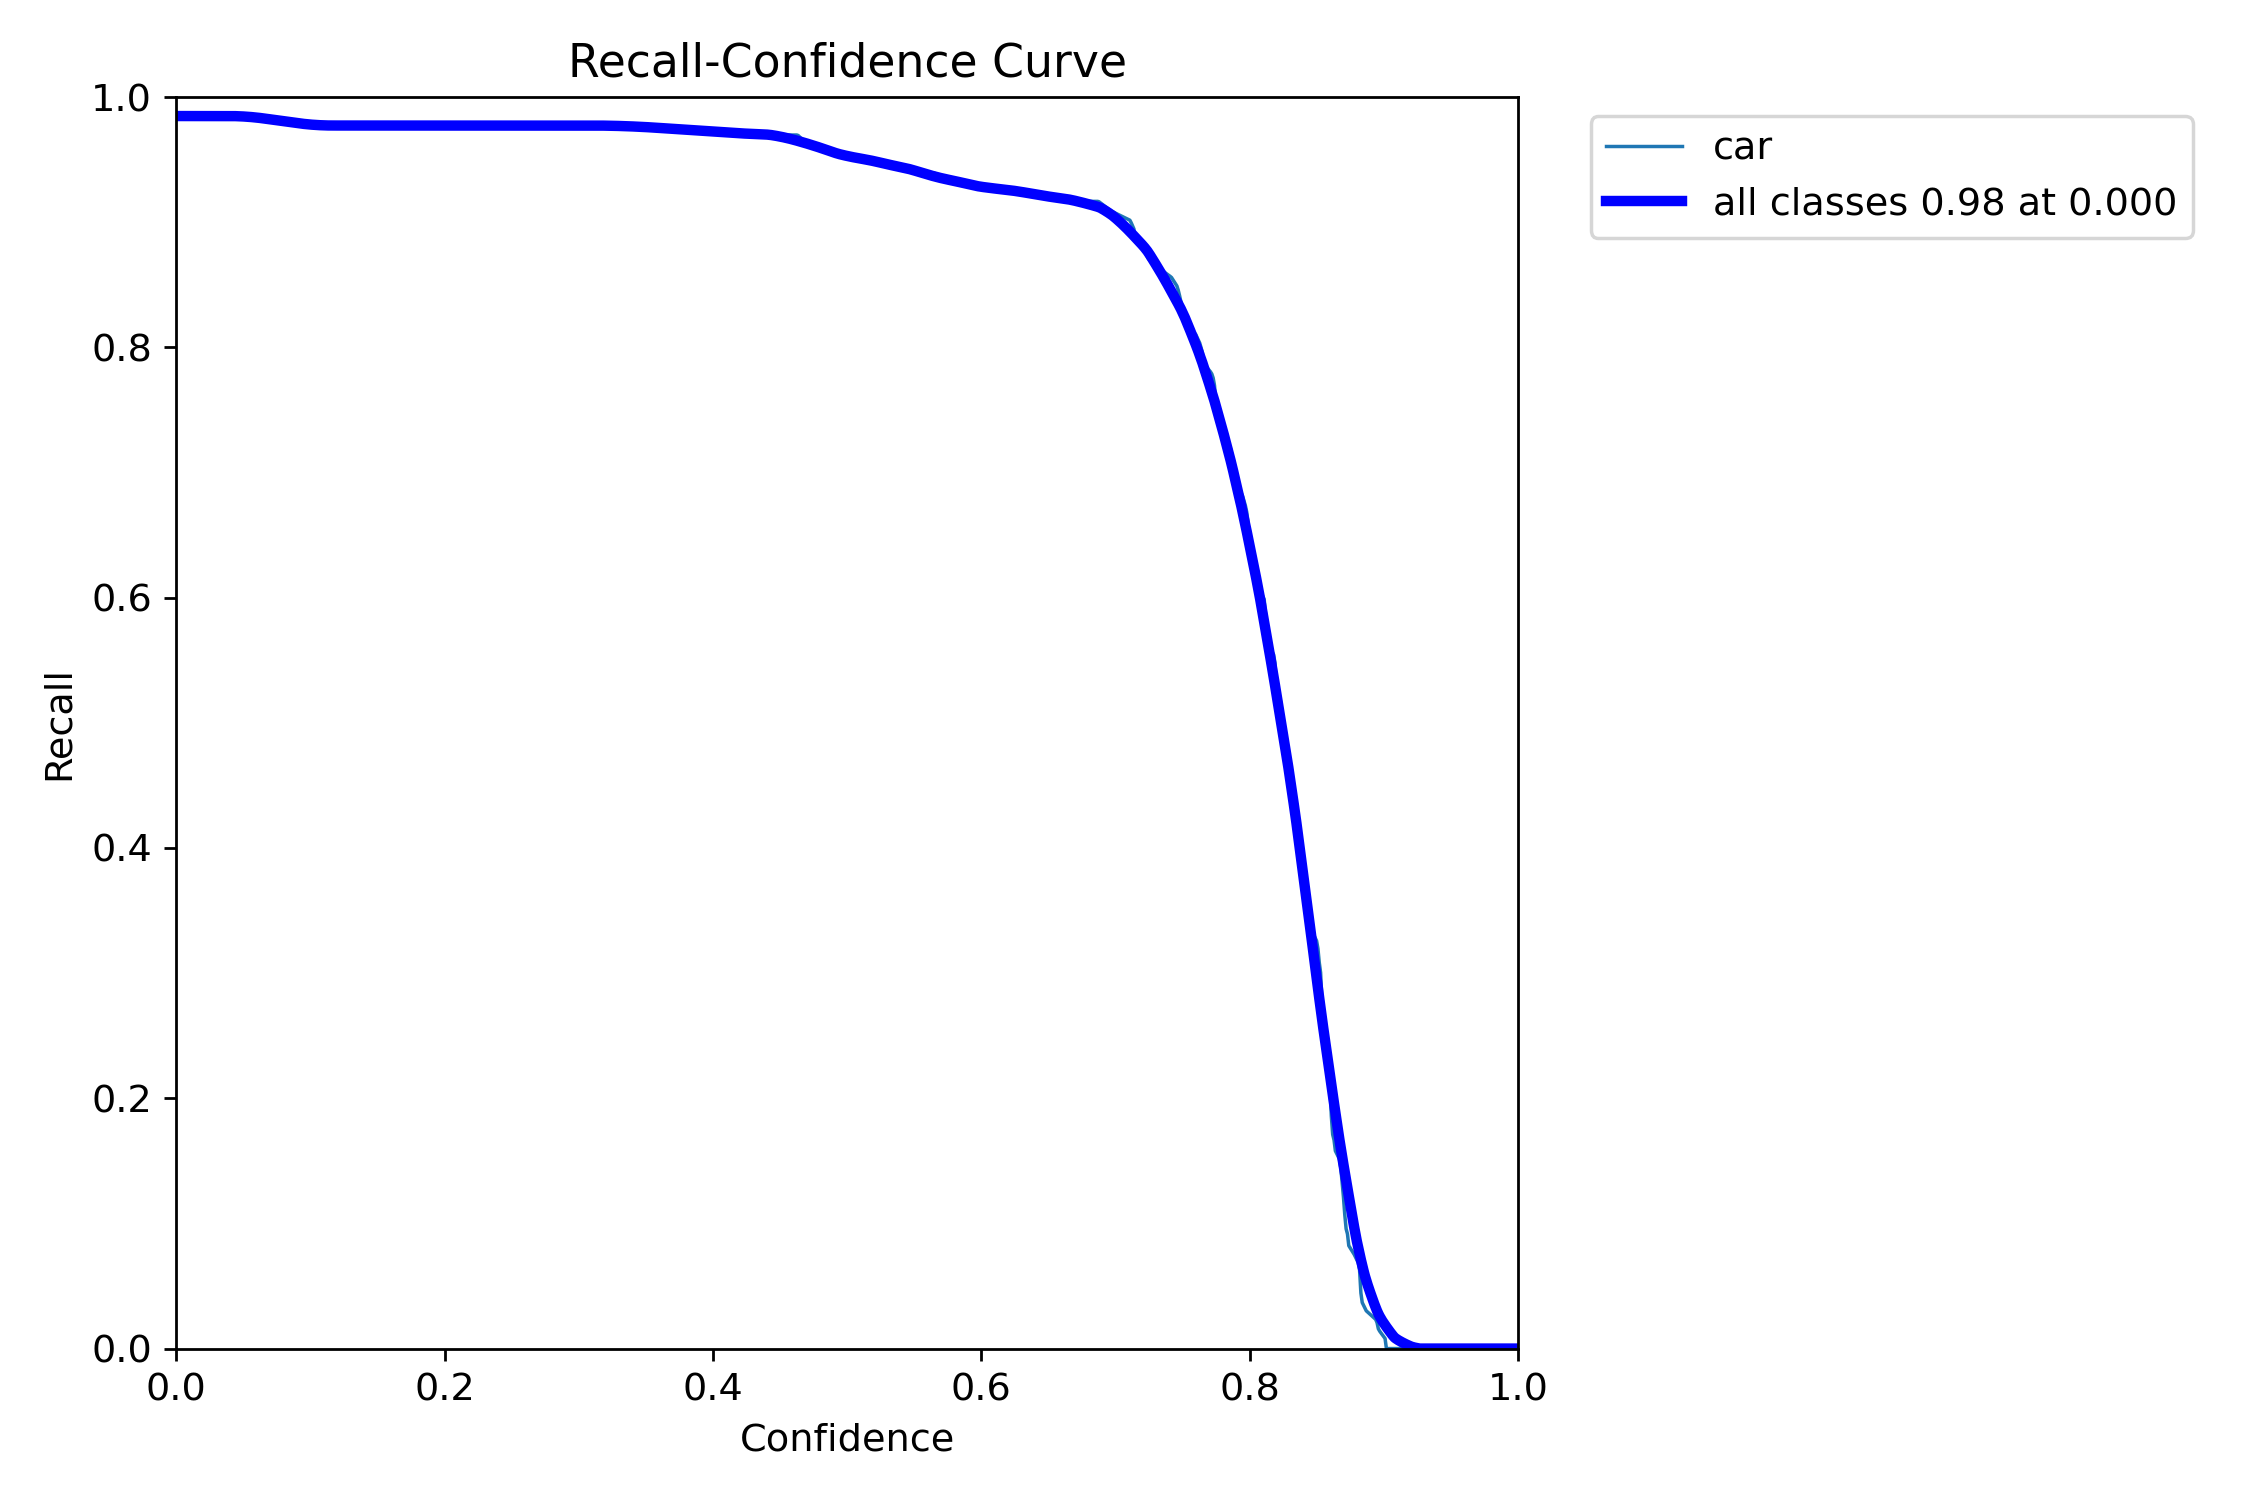

/content/runs/detect/val3/confusion_matrix.png


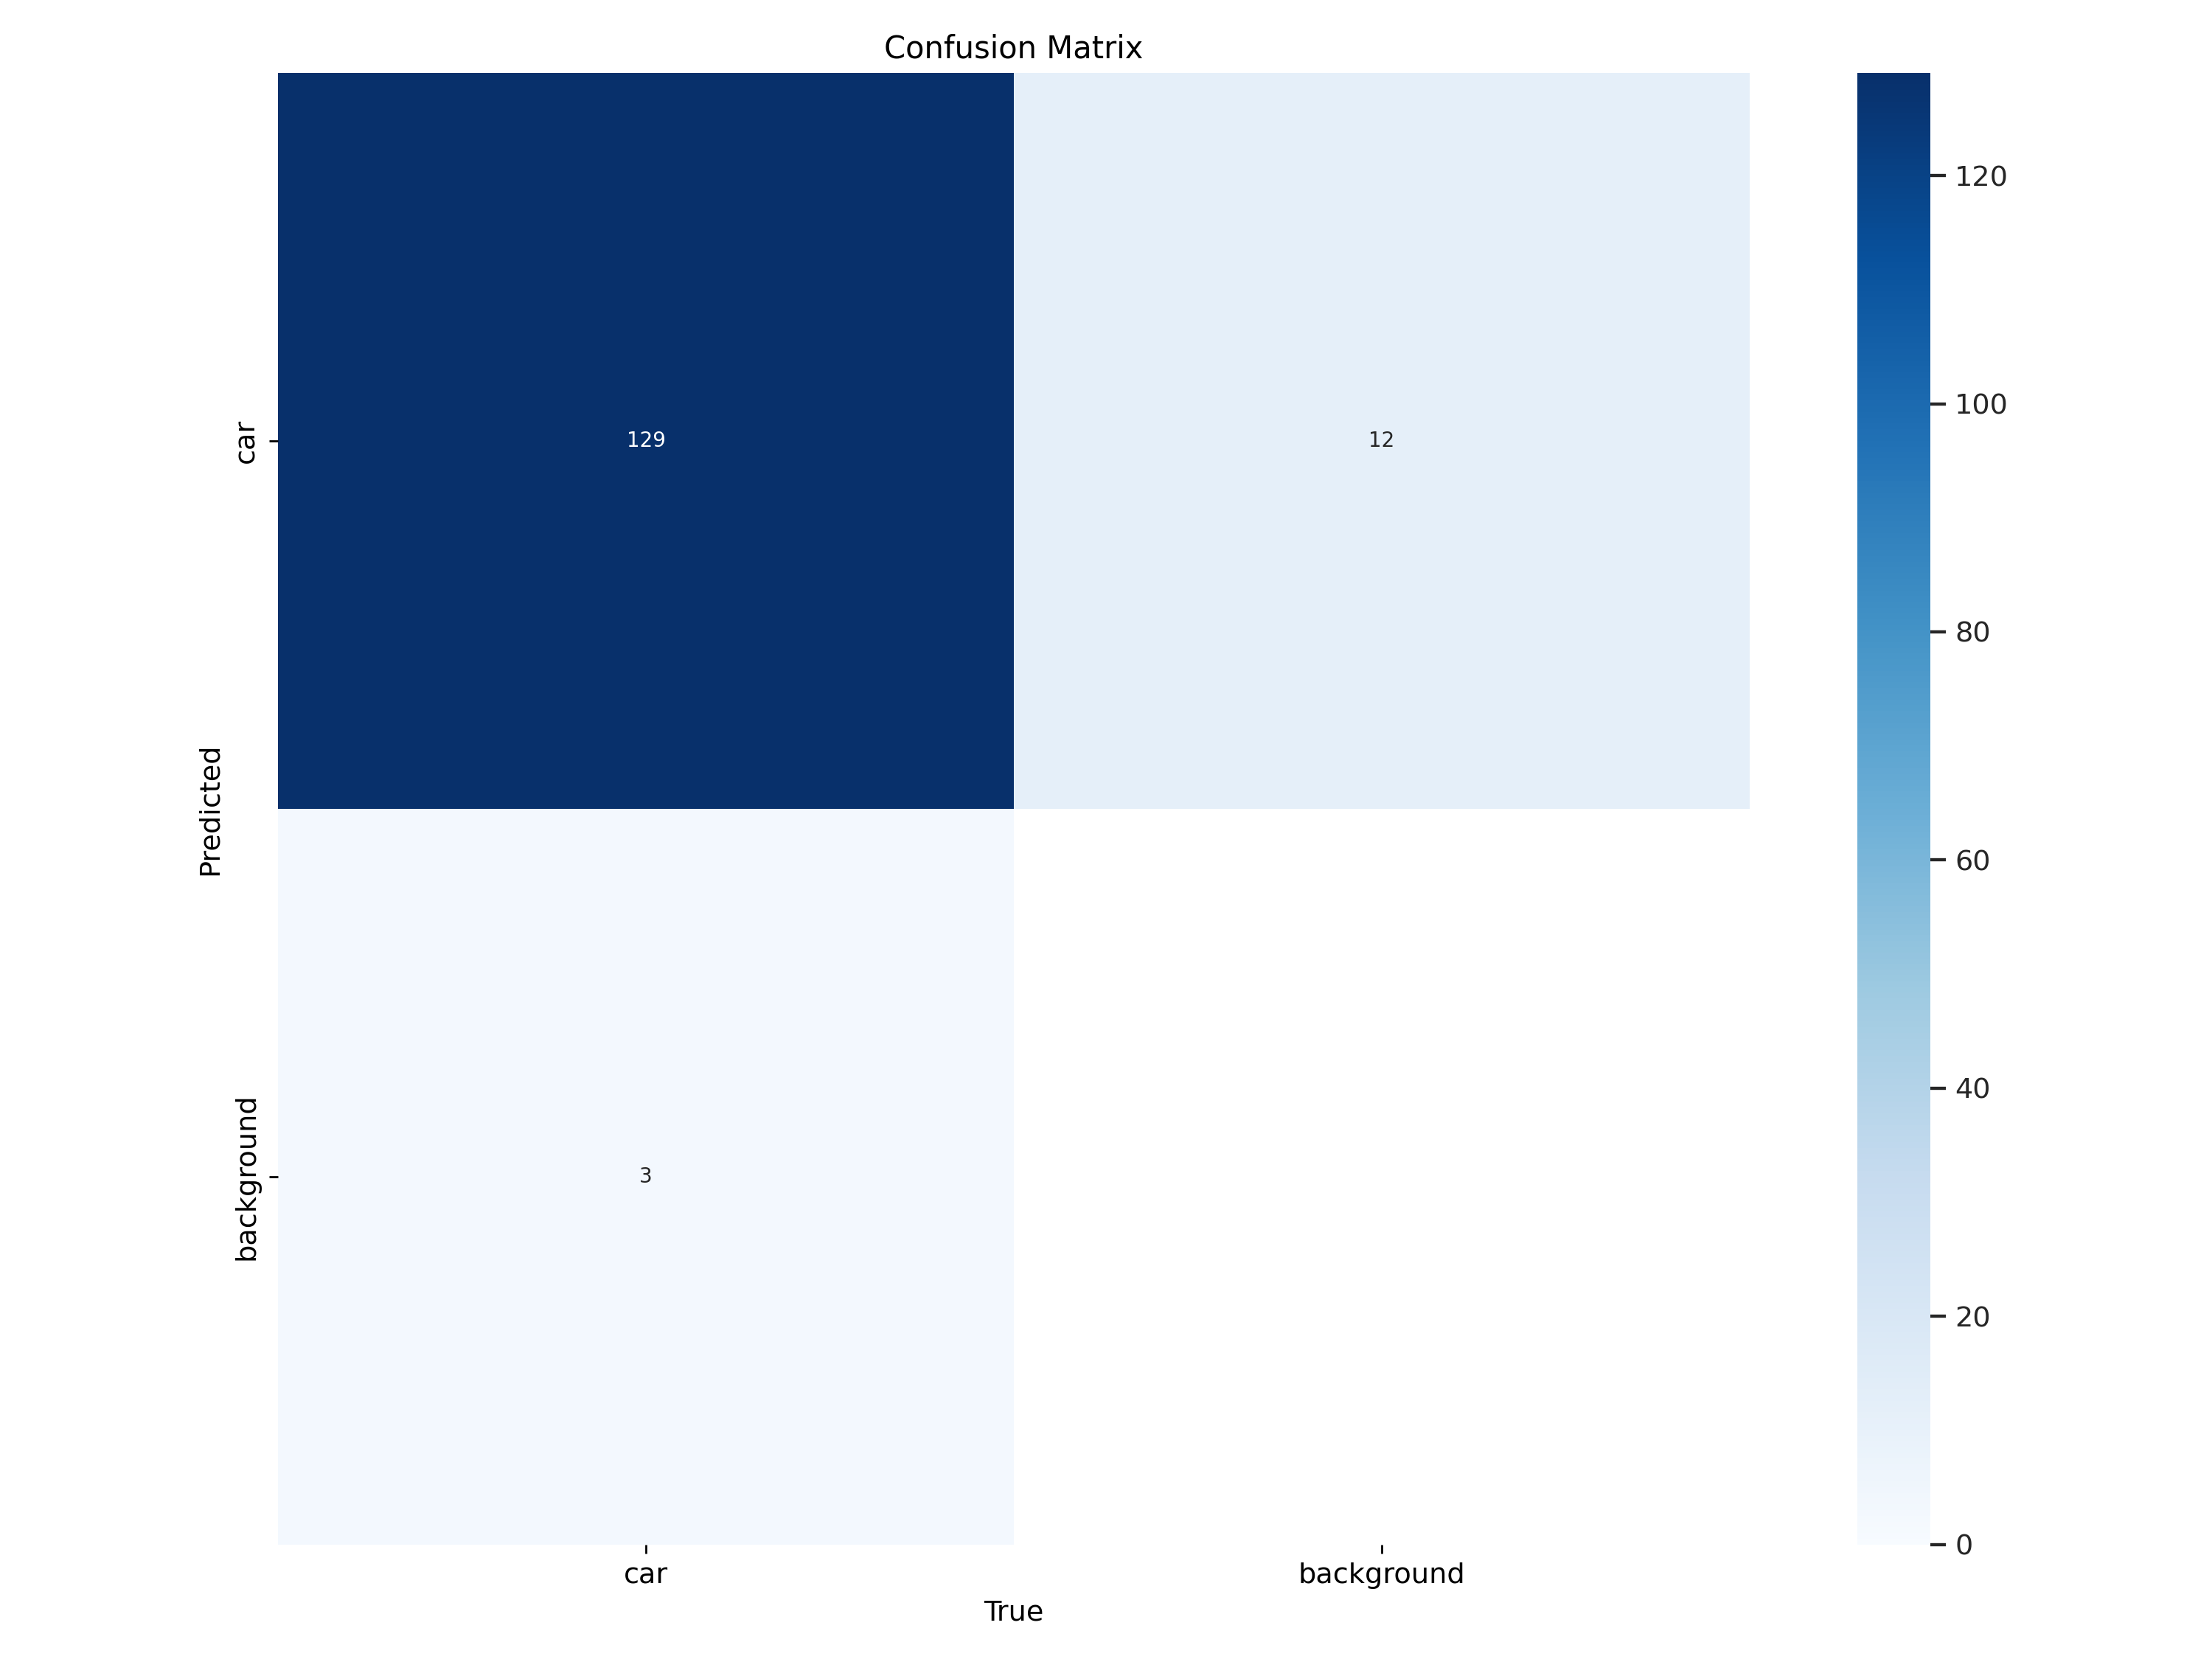

/content/runs/detect/val3/F1_curve.png


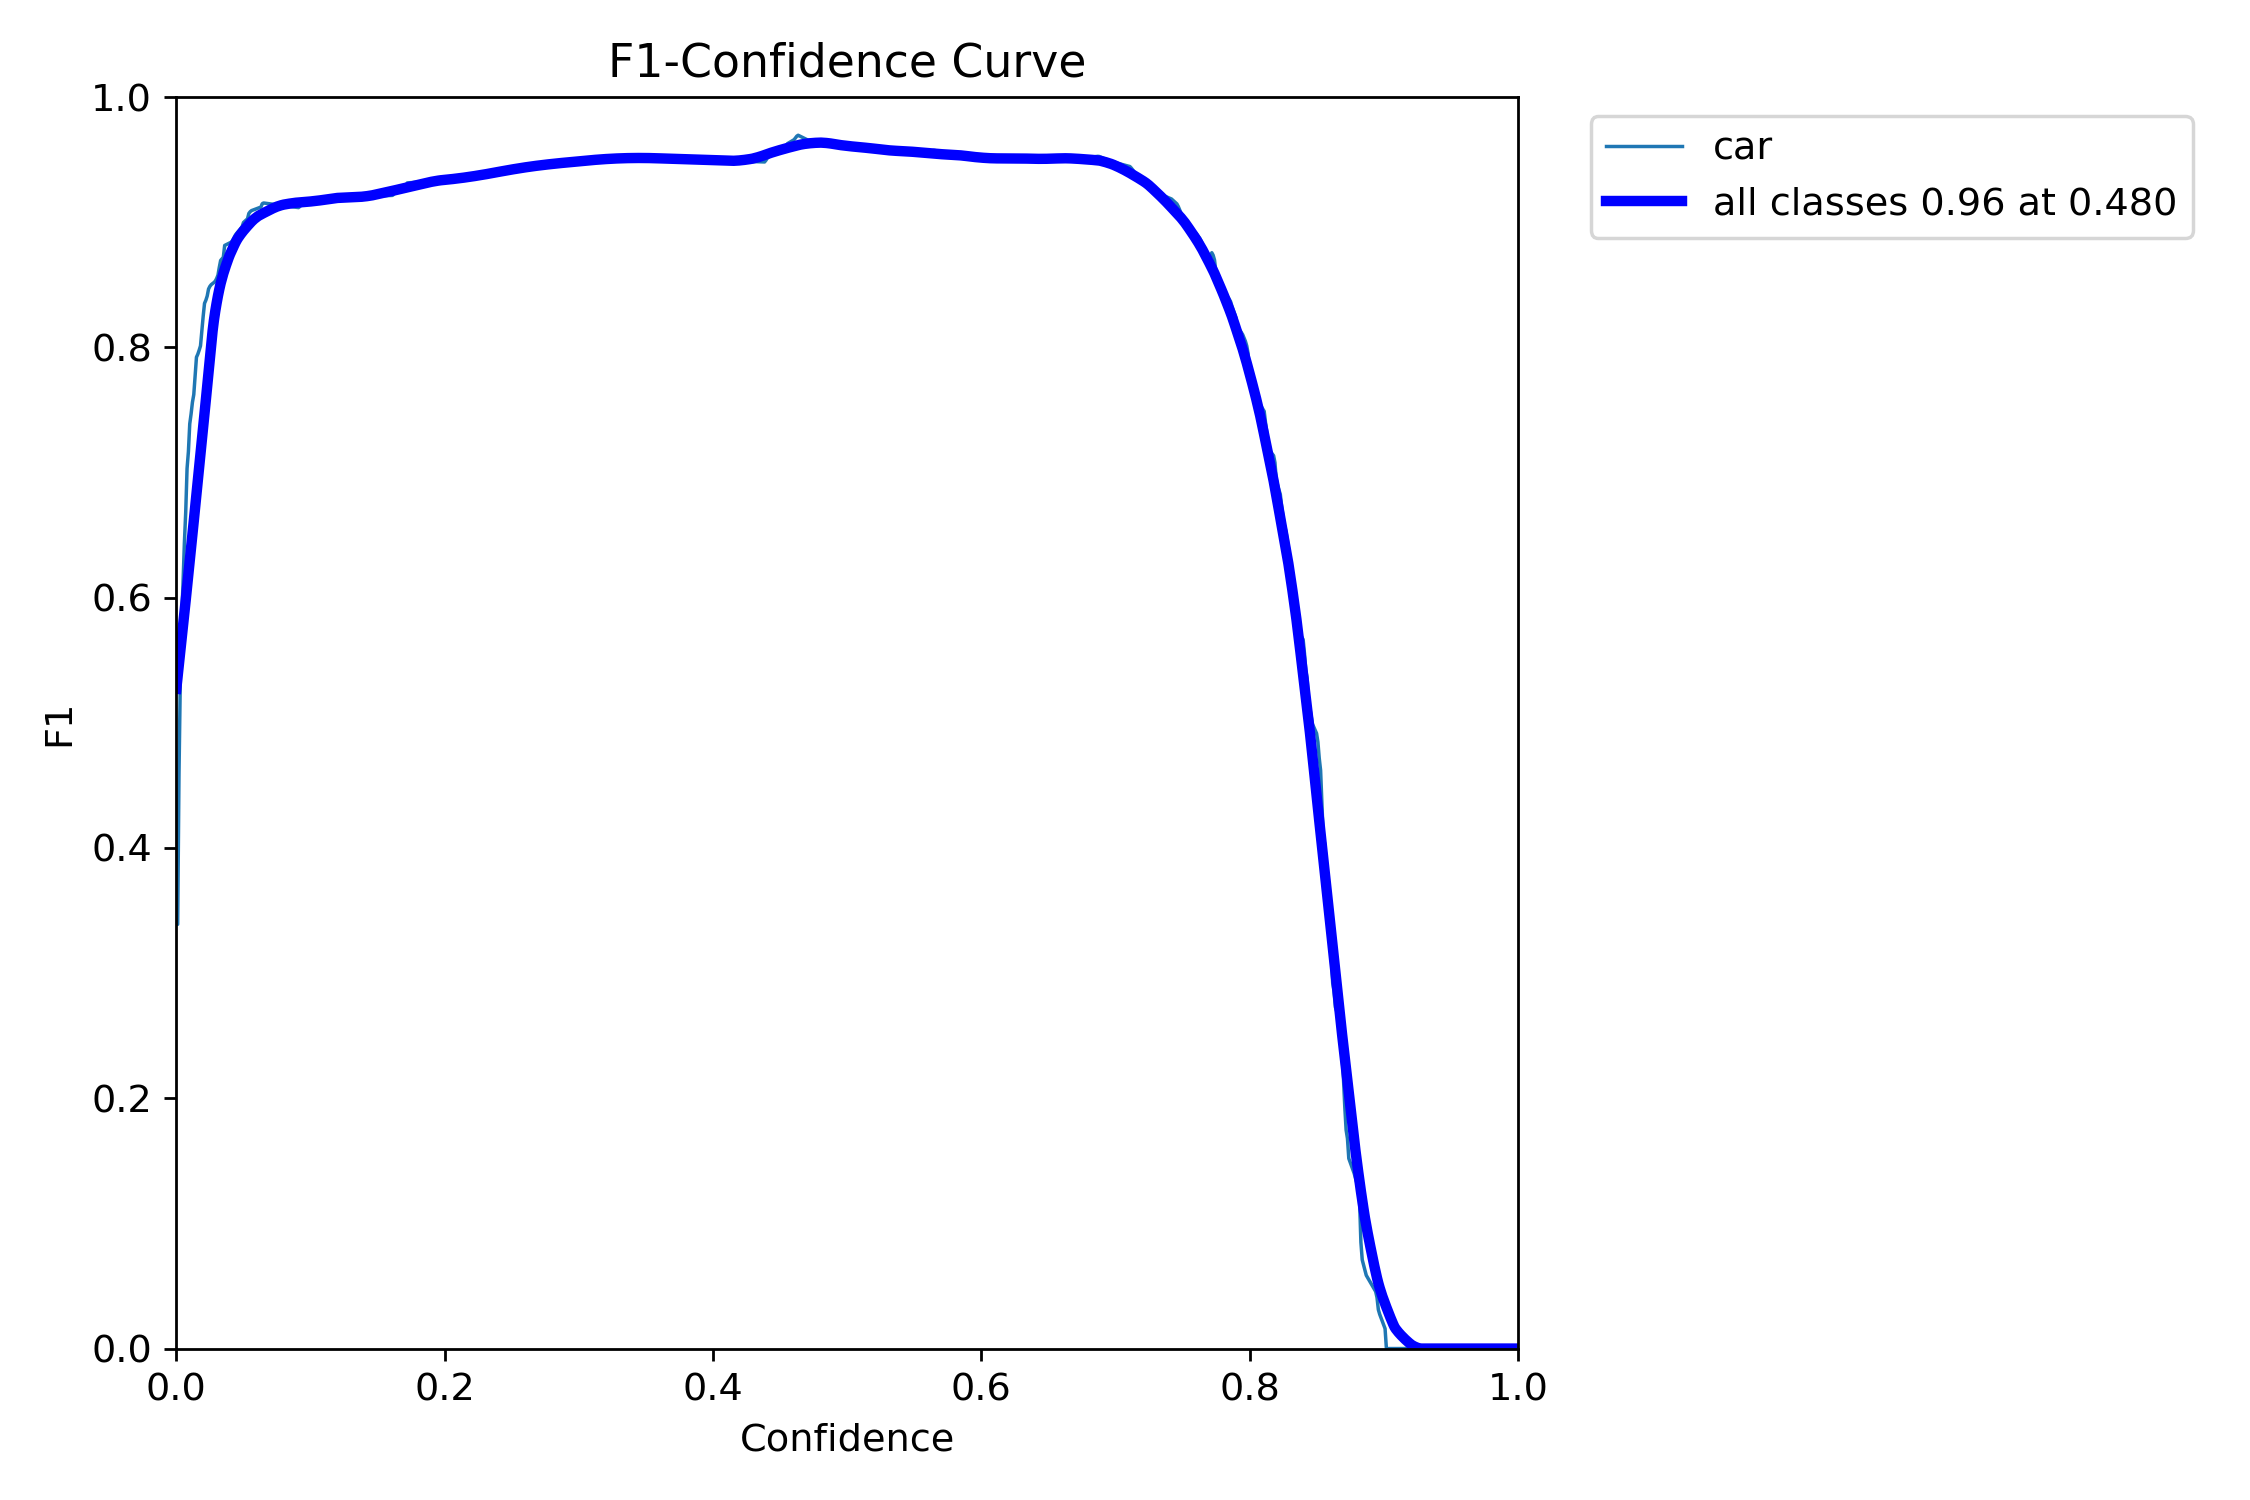

In [ ]:
from IPython.display import display, Image as IPyImage

for img in os.listdir('/content/runs/detect/val3'):
  print(f'/content/runs/detect/val3/{img}')
  display(IPyImage(filename=f'/content/runs/detect/val3/{img}', width=600))

In [ ]:
# сохраняю графики с метриками на test выборке
!zip -r rezult_test.zip /content/runs/detect/val3

  adding: content/runs/detect/val3/ (stored 0%)
  adding: content/runs/detect/val3/confusion_matrix_normalized.png (deflated 38%)
  adding: content/runs/detect/val3/val_batch0_labels.jpg (deflated 5%)
  adding: content/runs/detect/val3/val_batch0_pred.jpg (deflated 5%)
  adding: content/runs/detect/val3/val_batch2_pred.jpg (deflated 18%)
  adding: content/runs/detect/val3/val_batch1_pred.jpg (deflated 19%)
  adding: content/runs/detect/val3/P_curve.png (deflated 20%)
  adding: content/runs/detect/val3/PR_curve.png (deflated 28%)
  adding: content/runs/detect/val3/val_batch1_labels.jpg (deflated 19%)
  adding: content/runs/detect/val3/val_batch2_labels.jpg (deflated 11%)
  adding: content/runs/detect/val3/R_curve.png (deflated 19%)
  adding: content/runs/detect/val3/confusion_matrix.png (deflated 40%)
  adding: content/runs/detect/val3/F1_curve.png (deflated 17%)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load the exported ONNX model
onnx_model = YOLO("/content/best.onnx")

# Run inference
results = onnx_model("/content/vid_4_720.jpg", save=True)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirements ['onnx', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 209.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 274.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 221.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 265.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 14.8s, installed 2 packages: ['onnx', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Preferring ONNX Runtime AzureExecutionProvider

image 1/1 /content/vid_4_720.jpg: 640x640 2 cars, 154.5ms
Speed: 47.9ms preprocess, 154.5ms inference, 82.0ms postprocess per image at

In [ ]:
for result in results:
  for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Координаты прямоугольника
    print(x1, y1, x2, y2)
    print(int(box.conf[0]))
    print(int(box.cls[0]))

277 189 531 282
0
0
2 198 178 274
0
0
